In [1]:
import numpy as np
import pandas as pd
from numpy import array, linspace, arange, outer, trace, dot, pi, log, exp, sin, cos, sqrt, sign, diag
from scipy.linalg import eig, eigh, norm, svd, kron, expm, sqrtm, norm
from scipy.stats import gaussian_kde, unitary_group
from scipy.optimize import minimize, minimize_scalar
from scipy.stats import entropy
import qutip as qp
from qiskit.quantum_info import Operator
from qiskit.circuit import Parameter
from qiskit.compiler import transpile
from sklearn.metrics import accuracy_score, log_loss

import time
import random
from functools import reduce
from itertools import product

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.quantum_info import Choi, diamond_norm

import mpmath as mp
mp.dps = 250; mp.pretty = False

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rc
matplotlib.rc('font', family='CMU Serif')
matplotlib.rcParams['mathtext.fontset'] = 'cm' 
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
s0 = np.array([[1],
               [0]])
s1 = np.array([[0],
               [1]])
P0 = np.array([[1., 0.],
               [0., 0.]]) # |0><0|
P1 = np.array([[0., 0.],
               [0., 1.]]) # |1><1|
X = np.array([[0.,1.],
              [1.,0.]]) # X Pauli matrix
Y = np.array([[0.,-1.j],
              [1.j, 0.]]) # Y Pauli matrix
Z = np.array([[1., 0.],
              [0.,-1.]]) # Z Pauli matrix
I = np.array([[1.,0.],
              [0.,1.]]) # 2x2 identity matrix
H = (X + Z) / sqrt(2)
XX = kron(X, X)
YY = kron(Y, Y)
ZZ = kron(Z, Z)

In [3]:
def phi_generator(n_qubits, normalized=True):
    n_qubits_half = int(n_qubits / 2)
    d = 2**n_qubits_half
    basis = np.eye(d)
    phi_state = np.reshape(np.zeros(2**n_qubits), (2**n_qubits, -1))
    for vec in basis:
        phi_state += kron(np.reshape(vec, (d, -1)), np.reshape(vec, (d, -1)))
    if normalized == True:
        return phi_state / norm(phi_state)
    else:
        return phi_state

# Costs

In [4]:
def loglike_cost(y, p):
    
    """
        y -- labels
        p -- predictions
    """
    
    f = 0
    for i in range(len(y)):
        f -= y[i]*log(p[i]) + (1 - y[i])*log(1 - p[i])
    
    return f


def abs_dist(y, p):
    
    f = 0
    for i in range(len(y)):
        f +=  abs(y[i] - p[i])
    
    return f


def least_squares_cost(y, p):
    
    f = 0
    for i in range(len(y)):
        f +=  (y[i] - p[i])**2
    
    return f

# Channels

In [5]:
def amplitude_damping_channel(n_qubits, density_matrix, p, target_qubit):
    
    A_loc = [I] * n_qubits
    A_loc[target_qubit] = P0 + sqrt(1-p)*P1
    A_loc = reduce(kron, A_loc)
    
    B_loc = [I] * n_qubits
    B_loc[target_qubit] = sqrt(p)*np.array([[0, 1], [0, 0]])
    B_loc = reduce(kron, B_loc)
    
    new_density_matrix = A_loc.dot(density_matrix).dot(A_loc.conj().T) + B_loc.dot(density_matrix).dot(B_loc.conj().T)
        
    return new_density_matrix


def local_depolarizing_channel(n_qubits, density_matrix, p, target_qubit):
    
    X_loc = [I] * n_qubits
    X_loc[target_qubit] = X
    X_loc = reduce(kron, X_loc)
    
    Y_loc = [I] * n_qubits
    Y_loc[target_qubit] = Y
    Y_loc = reduce(kron, Y_loc)
    
    Z_loc = [I] * n_qubits
    Z_loc[target_qubit] = Z
    Z_loc = reduce(kron, Z_loc)
    
    new_density_matrix = (1 - p)*density_matrix + (X_loc.dot(density_matrix).dot(X_loc) + Y_loc.dot(density_matrix).dot(Y_loc) + Z_loc.dot(density_matrix).dot(Z_loc)) * p / 3
        
    return new_density_matrix


def colored_noise_channel(n_qubits, density_matrix, t, alpha, target_qubit, gamma1=1e-4, gamma2=1e4):

    if alpha == 1:
        a = mp.log(mp.fdiv(gamma2, gamma1))
        c = mp.fdiv(1, a)
        def p(gamma):
            return mp.fmul(c, mp.fdiv(1, gamma))
    else:
        k = mp.fsub(alpha, 1)
        a = mp.fmul(gamma1, gamma2)
        a_power = mp.power(a, k)
        b = mp.fsub(mp.power(gamma2, k), mp.power(gamma1, k))
        c = mp.fdiv(a_power, b)
        def p(gamma):
            pp = mp.power(gamma, alpha)
            f = mp.fdiv(k, pp)
            return mp.fmul(f, c)
   
    def G(gamma):
        delta = mp.sqrt(gamma**2 - 4)
        delta_t = mp.fmul(delta, t)
        second = mp.fadd(mp.cosh(delta_t), mp.fdiv(mp.fmul(gamma, mp.sinh(delta_t)), delta))
        gamma_t = mp.fmul(gamma, t)
        return mp.fmul(mp.exp(-gamma_t), second)
        
    L = mp.quad(lambda gamma: mp.fmul(p(gamma), G(gamma)), [gamma1, gamma2])
    L = float(L.real)
    operator = [I] * n_qubits
    operator[target_qubit] = Z
    operator = reduce(kron, operator)
    term1 = (1 + L) / 2 * density_matrix
    term2 = (1 - L) / 2 * operator.dot(density_matrix).dot(operator)
    
    return np.array(term1 + term2, dtype=complex)

### Ansatz

In [6]:
def su2_np(pars):
    return np.array([[exp(1j * (-pars[1] - pars[2])) * cos(pars[0]), -exp(1j * (-pars[1] + pars[2])) * sin(pars[0])],
                     [exp(1j * ( pars[1] - pars[2])) * sin(pars[0]),  exp(1j * ( pars[1] + pars[2])) * cos(pars[0])]])


def xz_rot(pars):
    return np.array([[exp(1j * -pars[1]) * cos(pars[0]), -exp(1j * -pars[1] ) * sin(pars[0])],
                     [exp(1j *  pars[1]) * sin(pars[0]),  exp(1j *  pars[1] ) * cos(pars[0])]])


def cr_y_np(n_qubits, q1, q2, par):
        
    cr_y_1 = reduce(kron, [np.eye(2**q1), P0, np.eye(2**(n_qubits-q1-1))])
    
    ry = np.array([[cos(par), -sin(par)], [sin(par), cos(par)]])
    if q2 > q1:
        cr_y_2 = [np.eye(2**q1), P1, np.eye(2**(q2-q1-1)), ry, np.eye(2**(n_qubits - q2 - 1))]
    else:
        cr_y_2 = [np.eye(2**q2), ry, np.eye(2**(q1-q2-1)), P1, np.eye(2**(n_qubits - q1 - 1))]
    cr_y_2 = reduce(kron, cr_y_2)

    return cr_y_1 + cr_y_2


def cx_np(n_qubits, q1, q2):
    
    cx_1 = reduce(kron, [np.eye(2**q1), P0, np.eye(2**(n_qubits-q1-1))])
    if q2 > q1:
        cx_2 = [np.eye(2**q1), P1, np.eye(2**(q2-q1-1)), X, np.eye(2**(n_qubits - q2 - 1))]
    else:
        cx_2 = [np.eye(2**q2), X, np.eye(2**(q1-q2-1)), P1, np.eye(2**(n_qubits - q1 - 1))]
    cx_2 = reduce(kron, cx_2)

    return cx_1 + cx_2


def hea_np(n_qubits, n_layers, pars):
    
    op = []
    pn = 0
    for l in range(n_layers):
        op_l = []
        for q in range(n_qubits):
            op_l.append(su2_np([pars[pn], pars[pn+1], pars[pn+2]]))
            pn += 3
        op.append(reduce(kron, op_l))
        
        op_l = []
        for q in range(n_qubits - 1):
            op_l.append(cr_y_np(n_qubits, q, q+1, pars[pn]))
            pn += 1
            
        if n_qubits > 2:
            op_l.append(cr_y_np(n_qubits, n_qubits-1, 0, pars[pn]))
            pn += 1
            
        op.append(reduce(dot, op_l))
        
    return reduce(dot, op)


def hea_np_t(n_qubits, n_layers, pars):
    
    op = []
    pn = 0
    for l in range(n_layers):
        op_l = []
        for q in range(n_qubits):
            op_l.append(xz_rot([pars[pn], pars[pn+1]]))
            # print(pars[pn])
            # print(pars[pn+1])
            # print(pars[pn+2])
            pn += 2
        op.append(reduce(kron, op_l))
        
        op_l = []
        for q in range(n_qubits - 1):
            op_l.append(cr_y_np(n_qubits, q, q+1, pars[pn]))
            # print(pars[pn])
            pn += 1
            
        if n_qubits > 2:
            op_l.append(cr_y_np(n_qubits, n_qubits-1, 0, pars[pn]))
            # print(pars[pn])
            pn += 1
            
        op.append(reduce(dot, op_l))
        
    return reduce(dot, op)


def hea_np_cx(n_qubits, n_layers, pars):
    
    op = []
    shift = 0
    for l in range(n_layers):
        op_l = []
        for q in range(n_qubits):
            op_l.append(xz_rot([pars[2*q+shift], pars[2*q+shift+1]]))
        shift += 2*n_qubits
        op.append(reduce(kron, op_l))
        
        op_l = []
        for q in range(n_qubits - 1):
            op_l.append(cx_np(n_qubits, q, q+1))
        if n_qubits > 2:
            op_l.append(cx_np(n_qubits, n_qubits-1, 0))
            
        op.append(reduce(dot, op_l))

    return reduce(dot, op)

### Original data

In [7]:
n_train = 1000 # train set size
n_test = 1000 # test set size

In [8]:
dm_train_o = [] # container for original density matrices
labels_train = [] # container for correct labels
dm_test_o = [] # container for original density matrices
for i in range(n_train):
    labels_train.append(random.randint(0, 1)) # store the class label
    # state_vector = np.array(qp.rand_ket(2)) # generate a random state
    # density_matrix = outer(state_vector, state_vector.conj().T) # consturct the corresponding density matrix
    density_matrix = np.array(qp.rand_dm_hs(2))
    dm_train_o.append(density_matrix) # store the original density matrix
    
print('Train 0s:', labels_train.count(0))
print('Train 1s:', labels_train.count(1))

Train 0s: 536
Train 1s: 464


In [9]:
dm_test_o = [] # container for original density matrices
labels_test = [] # container for correct labels
dm_test_o = [] # container for original density matrices
for i in range(n_test):
    labels_test.append(random.randint(0, 1)) # store the class label
    # state_vector = np.array(qp.rand_ket(2)) # generate a random state
    # density_matrix = outer(state_vector, state_vector.conj().T) # consturct the corresponding density matrix
    density_matrix = np.array(qp.rand_dm_hs(2))
    dm_test_o.append(density_matrix) # store the original density matrix
    
print('Test 0s:', labels_test.count(0))
print('Test 1s:', labels_test.count(1))

Test 0s: 523
Test 1s: 477


# Original and Noised

### Trainer, classifier

In [10]:
def train(dms_o, dms_n, labels, method, x0=None):
    
    f_values = [] # loss function values container
    n_train = len(labels) # training set size 

    obs = reduce(kron, [Z, Z])
    
    # trace function labeler
    def fun(x):
        
        unitary = kron(xz_rot(x[:2]), xz_rot(x[2:])) # construct the ansatz
        
        predictions = [] # predictions container
        for i in range(n_train):
            
            density_matrix = reduce(kron, [dms_o[i], dms_n[i]]) # construct the density matrix
            density_matrix = unitary.dot(density_matrix).dot(unitary.conj().T) # act with the ansatz
            
            # prediction = trace(dot(density_matrix, obs)).real # calculate the prediction (trace)
            prediction = (1 + trace(dot(density_matrix, obs)).real)/2 # calculate the prediction (trace)
            predictions.append(prediction) # store the prediction
        
        f = loglike_cost(labels, predictions) # feed predictions and labels into the least squares function
        f_values.append(f) # store the value of the cost
    
        return f
    
    n_pars = 4 # number of parameters in our ansatz
    bounds = None#[(-4*pi, 4*pi) for i in range(n_pars)] 
    if x0 is None:
        x0 = [random.uniform(-4*pi, 4*pi) for i in range(n_pars)] # initial parameters of the ansatz
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method) # optimization routine
    
    parameters = optimization_result.x # extract optimal ansatz parameters
    
    ### OPTIMAL BORDER###
    #get the predictions using the optimal parameters
    # unitary = su2(2, parameters) # construct the ansatz
    unitary = kron(xz_rot(parameters[:2]), xz_rot(parameters[2:]))
    predictions = [] # predictions container
    for i in range(n_train):

        density_matrix = reduce(kron, [dms_o[i], dms_n[i]]) # construct the density matrix
        density_matrix = unitary.dot(density_matrix).dot(unitary.conj().T) # act with the ansatz
        
        # prediction = trace(dot(density_matrix, obs)).real # calculate the prediction (trace)
        prediction = (1 + trace(dot(density_matrix, obs)).real)/2 # calculate the prediction (trace)
        predictions.append(prediction) # store the prediction
        
    #sort predictions in increasing order
    data = pd.DataFrame({'preds':predictions, 'labels':labels})
    data = data.sort_values(by = 'preds')
    predictions = data['preds'].values
    labels = data['labels'].values
    
    #train_accuracy for finding optimal border
    best_accuracy = 0
    for i in range(1, n_train):
        labels_pred = [0]*i + [1]*(n_train-i)
        accuracy = accuracy_score(labels, labels_pred)
        if accuracy>best_accuracy:
            best_accuracy = accuracy
            border = predictions[i]
    
    return f_values, parameters, optimization_result, border

In [11]:
def classify(parameters, dms_o, dms_n, border):
    
    assignments = [] # classification assignments container  
    predictions = [] # predictions container
    n_test = len(dms_n) # validation set size 
    
    obs = reduce(kron, [Z, Z])
    
    unitary = kron(xz_rot(parameters[:2]), xz_rot(parameters[2:])) # construct the ansatz with optimal parameters
    
    for i in range(n_test):

        density_matrix = reduce(kron, [dms_o[i], dms_n[i]]) # construct the density matrix
        density_matrix = unitary.dot(density_matrix).dot(unitary.conj().T) # act with the ansatz
        
        # prediction = trace(dot(density_matrix, obs)).real # calculate the prediction (trace)
        prediction = (1 + trace(dot(density_matrix, obs)).real)/2 # calculate the prediction (trace)
        predictions.append(prediction) # store the prediction
        
        # classify (assign a label)
        # the optimal value of 'border' you need to find
        if prediction < border: 
            assignment = 0
        elif prediction >= border:
            assignment = 1
        assignments.append(assignment) # store the label
        
    return predictions, assignments

### Training

In [75]:
alphas_possible = [0.7, 0.8] # alphas to classify between
channel_func = local_depolarizing_channel #

In [76]:
dm_train_n = []
for i in range(n_train):
    alpha = alphas_possible[labels_train[i]] # pick the corresponding alpha
    density_matrix = channel_func(1, dm_train_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
    dm_train_n.append(density_matrix) # store the noised density matrix    
    
dm_test_n = []
for i in range(n_test):
    alpha = alphas_possible[labels_test[i]] # pick the corresponding alpha
    density_matrix = channel_func(1, dm_test_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
    dm_test_n.append(density_matrix) # store the noised density matrix

Completed in 1.3634898662567139
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


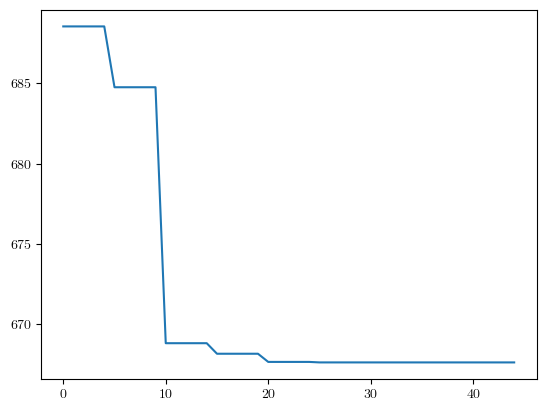

In [77]:
method = 'L-BFGS-B'

start_time = time.time()
f_values, parameters, optimization_result, border = train(dm_train_o, dm_train_n, labels_train, method, x0=None)
print('Completed in', time.time() - start_time)
print(optimization_result.message)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()

In [78]:
predictions_train, assignments_train = classify(parameters, dm_train_o, dm_train_n, border) # classify
predictions_test, assignments_test = classify(parameters, dm_test_o, dm_test_n, border) # classify

# calculate the accuracy
n_correct = 0
for i in range(n_train):
    if labels_train[i] == assignments_train[i]:
        n_correct += 1
acc_train = n_correct/n_train

# calculate the accuracy
n_correct = 0
for i in range(n_test):
    if labels_test[i] == assignments_test[i]:
        n_correct += 1
acc_test = n_correct/n_test

print("Accuracy:")
print("\t train:  ", acc_train)
print("\t test:   ", acc_test)

Accuracy:
	 train:   1.0
	 test:    1.0


#### Plots

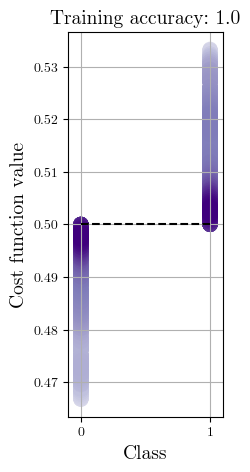

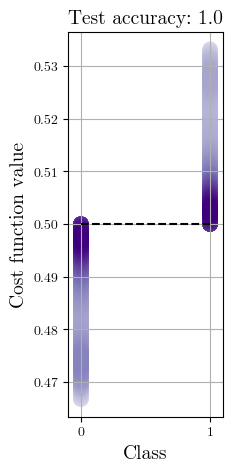

In [79]:
class_labels = [0, 1]
n_classes = len(class_labels)

predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_train):
    for j in range(n_classes):
        if labels_train[i] == class_labels[j]:
            predictions_plot[j].append(predictions_train[i])
cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0.25, 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('Purples', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=border, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Training accuracy: ' + str(acc_train), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
# plt.ylim(-0.3, 0.3)
plt.grid()
plt.show()

# plot all the stuff
predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_test):
    for j in range(n_classes):
        if labels_test[i] == class_labels[j]:
            predictions_plot[j].append(predictions_test[i])
cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0.25, 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('Purples', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=border, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Test accuracy: ' + str(acc_test), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
# plt.ylim(-0.3, 0.3)
plt.grid()
plt.show()

### Acc vs Alphas

### 2D

In [80]:
method = 'BFGS'
alphas_sets = [(0.1*i, 0.1*i+0.1) for i in range(10)] #+ [(0.0, 1.0)]
channel_func = local_depolarizing_channel #amplitude_damping_channel #

In [27]:
accs_train = []
accs_test = []
for a in range(len(alphas_sets)):
    
    if a == 0:
        x0 = None
    else:
        x0 = parameters
    
    alphas_possible = alphas_sets[a]
    # print("alphas:", np.round(alphas_possible, 2), end="\r")
    
    dm_train_n = []
    for i in range(n_train):
        alpha = alphas_possible[labels_train[i]] # pick the corresponding alpha
        density_matrix = channel_func(1, dm_train_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
        dm_train_n.append(density_matrix) # store the noised density matrix    

    dm_test_n = []
    for i in range(n_test):
        alpha = alphas_possible[labels_test[i]] # pick the corresponding alpha
        density_matrix = channel_func(1, dm_test_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
        dm_test_n.append(density_matrix) # store the noised density matrix

    f_values, parameters, optimization_result, border = train(dm_train_o, dm_train_n, labels_train, method, x0=x0)

    predictions_train, assignments_train = classify(parameters, dm_train_o, dm_train_n, border) # classify
    predictions_test, assignments_test = classify(parameters, dm_test_o, dm_test_n, border) # classify

    # calculate the accuracy
    n_correct = 0
    for i in range(n_train):
        if labels_train[i] == assignments_train[i]:
            n_correct += 1
    acc_train = n_correct/n_train

    # calculate the accuracy
    n_correct = 0
    for i in range(n_test):
        if labels_test[i] == assignments_test[i]:
            n_correct += 1
    acc_test = n_correct/n_test
    
    accs_train.append(acc_train)
    accs_test.append(acc_test)

    
    # print("\t train:", acc_train)
    # print("\t test: ", acc_test)

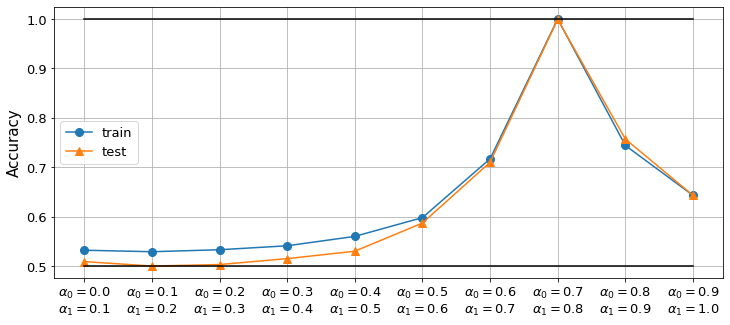

In [28]:
fontsize = 13
x_axis = [i for i in range(len(alphas_sets))]
plt.figure(figsize=(12, 5))
plt.plot(x_axis, accs_train, marker="o", label="train", markersize=8)
plt.plot(x_axis, accs_test, marker="^", label="test", markersize=8)
plt.plot(x_axis, [0.5 for i in range(len(alphas_sets))], color="black")
plt.plot(x_axis, [1.0 for i in range(len(alphas_sets))], color="black")
plt.xticks(x_axis, [r"$\alpha_0=" + str(round(alphas_sets[i][0], 2)) + r"$" + "\n" + r"$\alpha_1=" + str(round(alphas_sets[i][1], 2)) + r"$" for i in range(len(alphas_sets))], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize+2)
plt.legend(fontsize=fontsize)
plt.grid()
plt.show()

### Heatmaps

In [187]:
method = 'BFGS'
alphas = np.round(linspace(0, 1, 101), 2)
channel_func = local_depolarizing_channel #amplitude_damping_channel 

parameters = None
accs_train = 0.5*np.eye(len(alphas))
accs_test = 0.5*np.eye(len(alphas))
for a in range(len(alphas)):    
    for b in range(a):

        # x0 = parameters
        x0 = None

        alphas_possible = [alphas[a], alphas[b]]
        print(a, b, end="\r")

        dm_train_n = []
        for i in range(n_train):
            alpha = alphas_possible[labels_train[i]] # pick the corresponding alpha
            density_matrix = channel_func(1, dm_train_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
            dm_train_n.append(density_matrix) # store the noised density matrix    

        dm_test_n = []
        for i in range(n_test):
            alpha = alphas_possible[labels_test[i]] # pick the corresponding alpha
            density_matrix = channel_func(1, dm_test_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
            dm_test_n.append(density_matrix) # store the noised density matrix

        f_values, parameters, optimization_result, border = train(dm_train_o, dm_train_n, labels_train, method, x0=x0)

        predictions_train, assignments_train = classify(parameters, dm_train_o, dm_train_n, border) # classify
        predictions_test, assignments_test = classify(parameters, dm_test_o, dm_test_n, border) # classify

        # calculate the accuracy
        n_correct = 0
        for i in range(n_train):
            if labels_train[i] == assignments_train[i]:
                n_correct += 1
        acc_train = n_correct/n_train
        accs_train[a][b] = 1*acc_train
        accs_train[b][a] = 1*acc_train
        # calculate the accuracy
        n_correct = 0
        for i in range(n_test):
            if labels_test[i] == assignments_test[i]:
                n_correct += 1
        acc_test = n_correct/n_test
        accs_test[a][b] = 1*acc_test
        accs_test[b][a] = 1*acc_test


bell_sv = phi_generator(2, normalized=False)
bell_dm = np.outer(bell_sv, bell_sv.conj().T)
diams = 0.5*np.eye(len(alphas))
for a in range(len(alphas)):    
    for b in range(a):
        choi1 = Choi(channel_func(2, bell_dm, alphas[a], 0))
        choi2 = Choi(channel_func(2, bell_dm, alphas[b], 0))
        dia = diamond_norm(choi1 - choi2, solver='SCS').real 
        diams[a][b] = 0.5 + 0.25*dia
        diams[b][a] = 0.5 + 0.25*dia

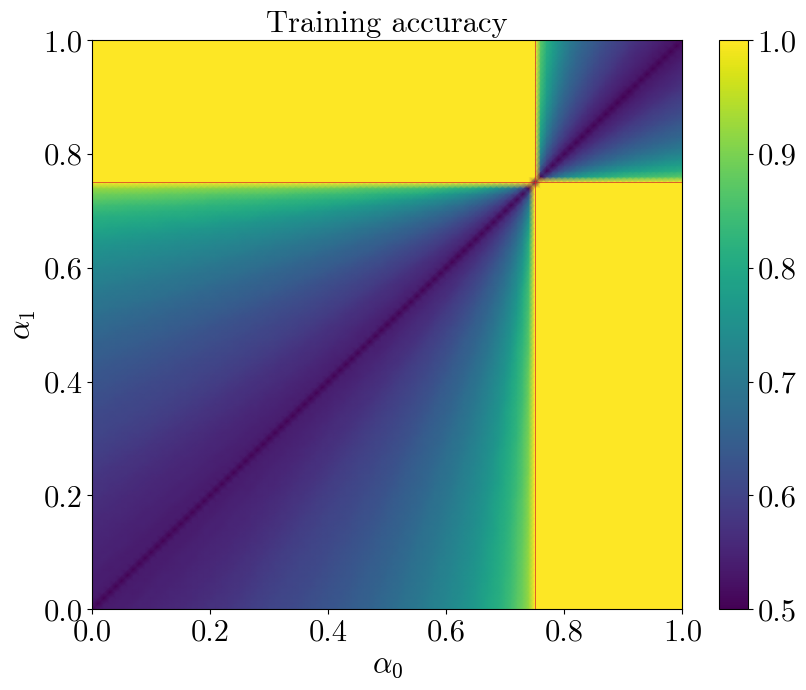

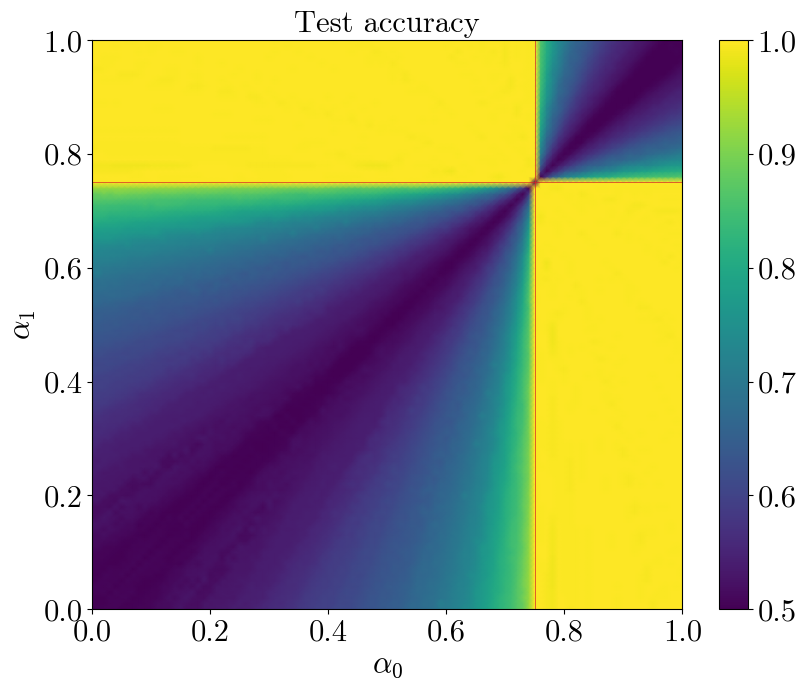

In [192]:
fontsize = 22

Xs, Ys, Zs = alphas, alphas, accs_train
plt.figure(figsize=(8.5, 7))
plt.pcolormesh(Xs, Ys, Zs, vmin=0.5, vmax=1.0, shading='gouraud')
plt.hlines(0.75, 0, 1, color="tab:red", linewidth=0.5)
plt.vlines(0.75, 0, 1, color="tab:red", linewidth=0.5)
plt.xlabel(r'$\alpha_0$', fontsize=fontsize)
plt.ylabel(r'$\alpha_1$', fontsize=fontsize)
plt.title(r'Training accuracy', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.colorbar().ax.tick_params(labelsize=fontsize)
plt.tight_layout()
plt.savefig('accuracy-train-noised+original-depolarizing-xz-heatmap.pdf', bbox_inches='tight', transparent=True)
plt.show()

Xs, Ys, Zs = alphas, alphas, accs_test
plt.figure(figsize=(8.5, 7))
plt.pcolormesh(Xs, Ys, Zs, vmin=0.5, vmax=1.0, shading='gouraud')
plt.hlines(0.75, 0, 1, color="tab:red", linewidth=0.5)
plt.vlines(0.75, 0, 1, color="tab:red", linewidth=0.5)
plt.xlabel(r'$\alpha_0$', fontsize=fontsize)
plt.ylabel(r'$\alpha_1$', fontsize=fontsize)
plt.title(r'Test accuracy', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.colorbar().ax.tick_params(labelsize=fontsize)
plt.tight_layout()
plt.savefig('accuracy-test-noised+original-depolarizing-xz-heatmap.pdf', bbox_inches='tight', transparent=True)
plt.show()

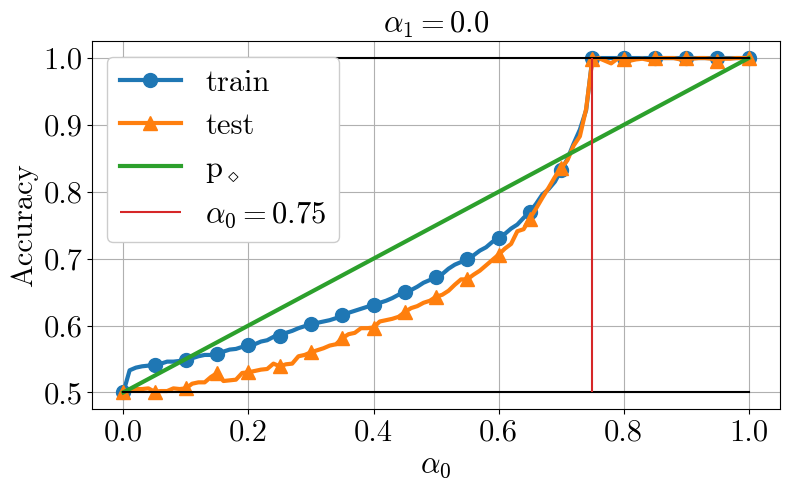

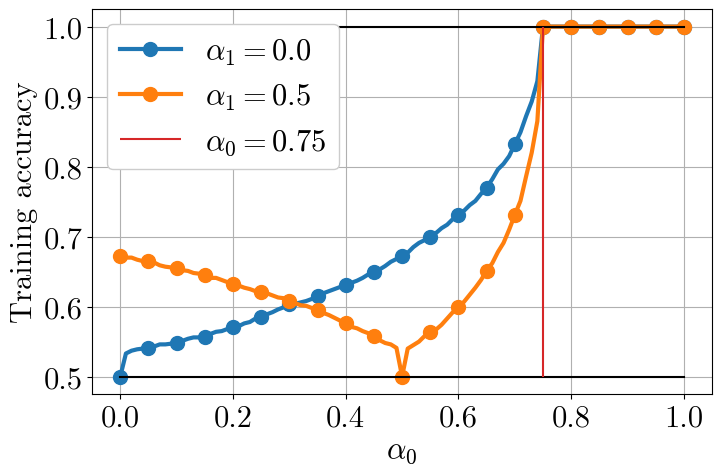

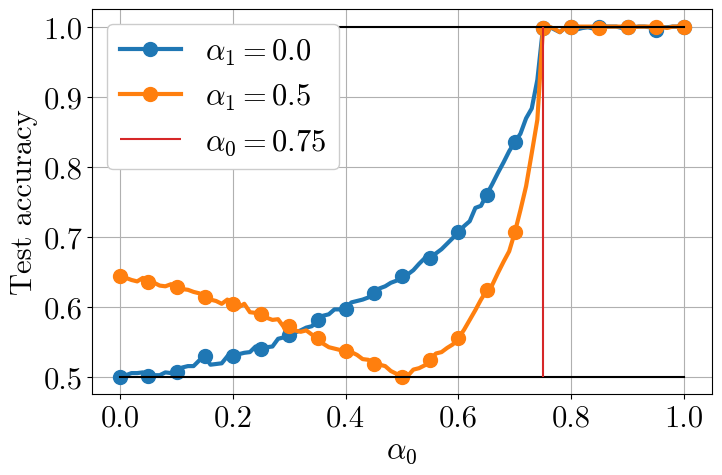

In [191]:
fontsize = 22
markersize = 10
markevery = 5
linewidth = 3

index = 0
plt.figure(figsize=(8, 5))
plt.plot(alphas, accs_train[index], marker="o", label="train", color="C0", linewidth=linewidth, markersize=markersize, markevery=markevery)
plt.plot(alphas, accs_test[index], marker="^", label="test", color="C1", linewidth=linewidth, markersize=markersize, markevery=markevery)
plt.plot(alphas, diams.T[index], label=r"$\mathrm{p}_\diamond$", color="C2", linewidth=linewidth, markersize=markersize, markevery=markevery)
plt.plot(alphas, [0.5 for i in range(len(alphas))], color="black")
plt.plot(alphas, [1.0 for i in range(len(alphas))], color="black")
plt.vlines(x=0.75, ymin=0.5, ymax=1, color="tab:red", label=r"$\alpha_0 = 0.75$")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"$\alpha_0$", fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.title(r"$\alpha_1=" + str(alphas[index]) + "$", fontsize=fontsize)
plt.legend(framealpha=1, fontsize=fontsize, loc=2)
plt.grid()
plt.tight_layout()
# plt.savefig('skooks.pdf', bbox_inches='tight')
plt.show()

indices = [0, 50]
plt.figure(figsize=(8, 5))
for index in indices:
    plt.plot(alphas, accs_train[index], label=r"$\alpha_1=" + str(alphas[index]) + "$", marker="o", linewidth=linewidth, markersize=markersize, markevery=markevery)
plt.plot(alphas, [0.5 for i in range(len(alphas))], color="black")
plt.plot(alphas, [1.0 for i in range(len(alphas))], color="black")
plt.vlines(x=0.75, ymin=0.5, ymax=1, color="tab:red", label=r"$\alpha_0 = 0.75$")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"$\alpha_0$", fontsize=fontsize)
plt.ylabel("Training accuracy", fontsize=fontsize)
plt.legend(framealpha=1, fontsize=fontsize, loc=2)
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
for index in indices:
    plt.plot(alphas, accs_test[index], label=r"$\alpha_1=" + str(alphas[index]) + "$", marker="o", linewidth=linewidth, markersize=markersize, markevery=markevery)
plt.plot(alphas, [0.5 for i in range(len(alphas))], color="black")
plt.plot(alphas, [1.0 for i in range(len(alphas))], color="black")
plt.vlines(x=0.75, ymin=0.5, ymax=1, color="tab:red", label=r"$\alpha_0 = 0.75$")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"$\alpha_0$", fontsize=fontsize)
plt.ylabel("Test accuracy", fontsize=fontsize)
plt.legend(framealpha=1, fontsize=fontsize, loc=2)
plt.grid()
plt.show()

In [12]:
method = 'BFGS'
index = 0
n_runs = 30
n_train = 1000 # train set size
n_test = 1000 # test set size
    
alphas = np.round(linspace(0, 1, 21), 2)
channel_func = local_depolarizing_channel #amplitude_damping_channel 

accs_train = []
accs_test = []
for r in range(n_runs):

    dm_train_o = [] # container for original density matrices
    labels_train = [] # container for correct labels
    dm_test_o = [] # container for original density matrices
    for i in range(n_train):
        labels_train.append(random.randint(0, 1)) # store the class label
        # state_vector = np.array(qp.rand_ket(2)) # generate a random state
        # density_matrix = outer(state_vector, state_vector.conj().T) # consturct the corresponding density matrix
        density_matrix = np.array(qp.rand_dm_hs(2))
        dm_train_o.append(density_matrix) # store the original density matrix

    dm_test_o = [] # container for original density matrices
    labels_test = [] # container for correct labels
    dm_test_o = [] # container for original density matrices
    for i in range(n_test):
        labels_test.append(random.randint(0, 1)) # store the class label
        # state_vector = np.array(qp.rand_ket(2)) # generate a random state
        # density_matrix = outer(state_vector, state_vector.conj().T) # consturct the corresponding density matrix
        density_matrix = np.array(qp.rand_dm_hs(2))
        dm_test_o.append(density_matrix) # store the original density matrix

    parameters = None
    accs_train_loc = []
    accs_test_loc = []
    for a in range(len(alphas)):    

            # x0 = parameters
            x0 = None

            alphas_possible = [alphas[a], alphas[index]]
            print(r, a, end="\r")

            dm_train_n = []
            for i in range(n_train):
                alpha = alphas_possible[labels_train[i]] # pick the corresponding alpha
                density_matrix = channel_func(1, dm_train_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
                dm_train_n.append(density_matrix) # store the noised density matrix    

            dm_test_n = []
            for i in range(n_test):
                alpha = alphas_possible[labels_test[i]] # pick the corresponding alpha
                density_matrix = channel_func(1, dm_test_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
                dm_test_n.append(density_matrix) # store the noised density matrix

            f_values, parameters, optimization_result, border = train(dm_train_o, dm_train_n, labels_train, method, x0=x0)

            predictions_train, assignments_train = classify(parameters, dm_train_o, dm_train_n, border) # classify
            predictions_test, assignments_test = classify(parameters, dm_test_o, dm_test_n, border) # classify

            # calculate the accuracy
            n_correct = 0
            for i in range(n_train):
                if labels_train[i] == assignments_train[i]:
                    n_correct += 1
            acc_train = n_correct/n_train
            accs_train_loc.append(acc_train)
            # calculate the accuracy
            n_correct = 0
            for i in range(n_test):
                if labels_test[i] == assignments_test[i]:
                    n_correct += 1
            acc_test = n_correct/n_test
            accs_test_loc.append(acc_test)
    accs_train.append(accs_train_loc)
    accs_test.append(accs_test_loc)

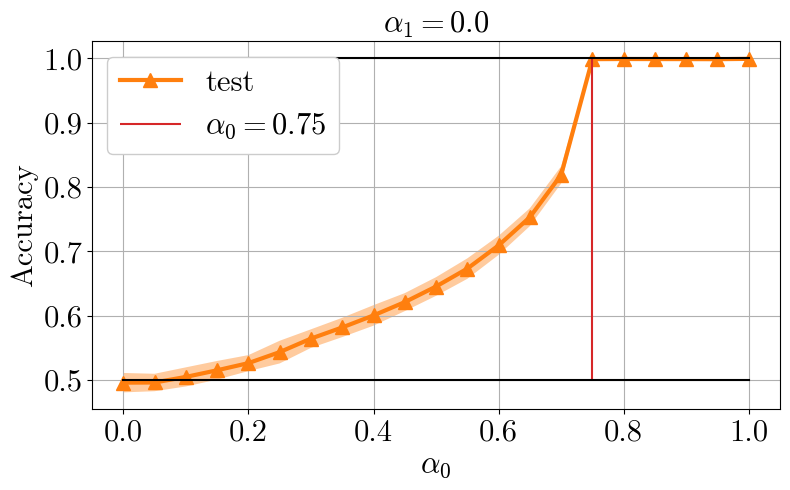

In [13]:
fontsize = 22
markersize = 10
markevery = 1
linewidth = 3
plt.figure(figsize=(8, 5))
# plt.fill_between(alphas, mean(accs_train, axis=0) - np.std(accs_train, axis=0), mean(accs_train, axis=0) + np.std(accs_train, axis=0), alpha=0.4, color="C0", edgecolor="none")
plt.fill_between(alphas, np.mean(accs_test, axis=0) - np.std(accs_test, axis=0), np.mean(accs_test, axis=0) + np.std(accs_test, axis=0), alpha=0.4, color="C1", edgecolor="none")
# plt.plot(alphas, mean(accs_train, axis=0), marker="o", label="train", color="C0", linewidth=linewidth, markersize=markersize, markevery=markevery)
plt.plot(alphas, np.mean(accs_test, axis=0), marker="^", label="test", color="C1", linewidth=linewidth, markersize=markersize, markevery=markevery)
plt.vlines(x=0.75, ymin=0.5, ymax=1, color="tab:red", label=r"$\alpha_0 = 0.75$")
plt.plot(alphas, [0.5 for i in range(len(alphas))], color="black")
plt.plot(alphas, [1.0 for i in range(len(alphas))], color="black")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"$\alpha_0$", fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.title(r"$\alpha_1=" + str(alphas[index]) + "$", fontsize=fontsize)
plt.legend(framealpha=1, fontsize=fontsize, loc=2)
plt.grid()
plt.tight_layout()
# plt.savefig("accuracy-noised+original-depolarizing-xz-alpha1=" + str(alphas[index]) + ".pdf", bbox_inches='tight', transparent=True)
plt.show()

In [14]:
# accs_test_no = array(accs_test)

# Original and Noised (HEA)

### Trainer, classifier

In [14]:
def train(dms_o, dms_n, labels, method, x0=None):
    
    f_values = [] # loss function values container
    n_train = len(labels) # training set size 

    obs = reduce(kron, [Z, Z])
    
    # trace function labeler
    def fun(x):
        
        unitary = hea_np(2, 1, x) # construct the ansatz
        
        predictions = [] # predictions container
        for i in range(n_train):
            
            density_matrix = reduce(kron, [dms_o[i], dms_n[i]]) # construct the density matrix
            density_matrix = unitary.dot(density_matrix).dot(unitary.conj().T) # act with the ansatz
            
            # prediction = trace(dot(density_matrix, obs)).real # calculate the prediction (trace)
            prediction = (1 + trace(dot(density_matrix, obs)).real)/2 # calculate the prediction (trace)
            predictions.append(prediction) # store the prediction
        
        f = loglike_cost(labels, predictions) # feed predictions and labels into the least squares function
        f_values.append(f) # store the value of the cost
    
        return f
    
    n_pars = 7 # number of parameters in our ansatz
    bounds = None#[(-4*pi, 4*pi) for i in range(n_pars)] 
    if x0 is None:
        x0 = [random.uniform(-4*pi, 4*pi) for i in range(n_pars)] # initial parameters of the ansatz
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method) # optimization routine
    
    parameters = optimization_result.x # extract optimal ansatz parameters
    
    ### OPTIMAL BORDER###
    #get the predictions using the optimal parameters
    # unitary = su2(2, parameters) # construct the ansatz
    unitary = hea_np(2, 1, parameters)
    predictions = [] # predictions container
    for i in range(n_train):

        density_matrix = reduce(kron, [dms_o[i], dms_n[i]]) # construct the density matrix
        density_matrix = unitary.dot(density_matrix).dot(unitary.conj().T) # act with the ansatz
        
        # prediction = trace(dot(density_matrix, obs)).real # calculate the prediction (trace)
        prediction = (1 + trace(dot(density_matrix, obs)).real)/2 # calculate the prediction (trace)
        predictions.append(prediction) # store the prediction
        
    #sort predictions in increasing order
    data = pd.DataFrame({'preds':predictions, 'labels':labels})
    data = data.sort_values(by = 'preds')
    predictions = data['preds'].values
    labels = data['labels'].values
    
    #train_accuracy for finding optimal border
    best_accuracy = 0
    for i in range(1, n_train):
        labels_pred = [0]*i + [1]*(n_train-i)
        accuracy = accuracy_score(labels, labels_pred)
        if accuracy>best_accuracy:
            best_accuracy = accuracy
            border = predictions[i]
    
    return f_values, parameters, optimization_result, border

In [15]:
def classify(parameters, dms_o, dms_n, border):
    
    assignments = [] # classification assignments container  
    predictions = [] # predictions container
    n_test = len(dms_n) # validation set size 
    
    obs = reduce(kron, [Z, Z])
    
    unitary = hea_np(2, 1, parameters) # construct the ansatz with optimal parameters
    
    for i in range(n_test):

        density_matrix = reduce(kron, [dms_o[i], dms_n[i]]) # construct the density matrix
        density_matrix = unitary.dot(density_matrix).dot(unitary.conj().T) # act with the ansatz
        
        # prediction = trace(dot(density_matrix, obs)).real # calculate the prediction (trace)
        prediction = (1 + trace(dot(density_matrix, obs)).real)/2 # calculate the prediction (trace)
        predictions.append(prediction) # store the prediction
        
        # classify (assign a label)
        # the optimal value of 'border' you need to find
        if prediction < border: 
            assignment = 0
        elif prediction >= border:
            assignment = 1
        assignments.append(assignment) # store the label
        
    return predictions, assignments

### Training

In [21]:
alphas_possible = [0.7, 0.8] # alphas to classify between
channel_func = local_depolarizing_channel #

In [22]:
dm_train_n = []
for i in range(n_train):
    alpha = alphas_possible[labels_train[i]] # pick the corresponding alpha
    density_matrix = channel_func(1, dm_train_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
    dm_train_n.append(density_matrix) # store the noised density matrix    
    
dm_test_n = []
for i in range(n_test):
    alpha = alphas_possible[labels_test[i]] # pick the corresponding alpha
    density_matrix = channel_func(1, dm_test_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
    dm_test_n.append(density_matrix) # store the noised density matrix

Completed in 3.3206946849823
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


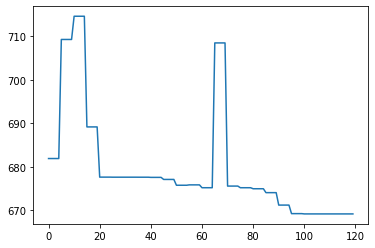

In [23]:
method = 'L-BFGS-B'

start_time = time.time()
f_values, parameters, optimization_result, border = train(dm_train_o, dm_train_n, labels_train, method, x0=None)
print('Completed in', time.time() - start_time)
print(optimization_result.message)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()

In [24]:
predictions_train, assignments_train = classify(parameters, dm_train_o, dm_train_n, border) # classify
predictions_test, assignments_test = classify(parameters, dm_test_o, dm_test_n, border) # classify

# calculate the accuracy
n_correct = 0
for i in range(n_train):
    if labels_train[i] == assignments_train[i]:
        n_correct += 1
acc_train = n_correct/n_train

# calculate the accuracy
n_correct = 0
for i in range(n_test):
    if labels_test[i] == assignments_test[i]:
        n_correct += 1
acc_test = n_correct/n_test

print("Accuracy:")
print("\t train:  ", acc_train)
print("\t test:   ", acc_test)

Accuracy:
	 train:   1.0
	 test:    0.999


#### Plots

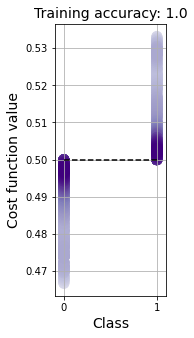

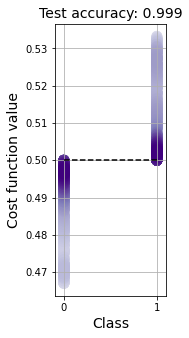

In [25]:
class_labels = [0, 1]
n_classes = len(class_labels)

predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_train):
    for j in range(n_classes):
        if labels_train[i] == class_labels[j]:
            predictions_plot[j].append(predictions_train[i])
cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0.25, 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('Purples', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=border, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Training accuracy: ' + str(acc_train), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
# plt.ylim(-0.3, 0.3)
plt.grid()
plt.show()

# plot all the stuff
predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_test):
    for j in range(n_classes):
        if labels_test[i] == class_labels[j]:
            predictions_plot[j].append(predictions_test[i])
cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0.25, 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('Purples', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=border, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Test accuracy: ' + str(acc_test), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
# plt.ylim(-0.3, 0.3)
plt.grid()
plt.show()

### Acc vs Alphas

### 2D

In [18]:
method = 'L-BFGS-B'
alphas_sets = [(0.1*i, 0.1*i+0.1) for i in range(10)] #+ [(0.0, 1.0)]
channel_func = local_depolarizing_channel #amplitude_damping_channel #

In [20]:
accs_train = []
accs_test = []
for a in range(len(alphas_sets)):
    
    print(a)
    
    if a == 0:
        x0 = None
    else:
        x0 = parameters
    
    alphas_possible = alphas_sets[a]
    # print("alphas:", np.round(alphas_possible, 2), end="\r")
    
    dm_train_n = []
    for i in range(n_train):
        alpha = alphas_possible[labels_train[i]] # pick the corresponding alpha
        density_matrix = channel_func(1, dm_train_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
        dm_train_n.append(density_matrix) # store the noised density matrix    

    dm_test_n = []
    for i in range(n_test):
        alpha = alphas_possible[labels_test[i]] # pick the corresponding alpha
        density_matrix = channel_func(1, dm_test_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
        dm_test_n.append(density_matrix) # store the noised density matrix

    f_values, parameters, optimization_result, border = train(dm_train_o, dm_train_n, labels_train, method, x0=x0)

    predictions_train, assignments_train = classify(parameters, dm_train_o, dm_train_n, border) # classify
    predictions_test, assignments_test = classify(parameters, dm_test_o, dm_test_n, border) # classify

    # calculate the accuracy
    n_correct = 0
    for i in range(n_train):
        if labels_train[i] == assignments_train[i]:
            n_correct += 1
    acc_train = n_correct/n_train

    # calculate the accuracy
    n_correct = 0
    for i in range(n_test):
        if labels_test[i] == assignments_test[i]:
            n_correct += 1
    acc_test = n_correct/n_test
    
    accs_train.append(acc_train)
    accs_test.append(acc_test)

    
    # print("\t train:", acc_train)
    # print("\t test: ", acc_test)

0
1
2
3
4
5
6
7
8
9


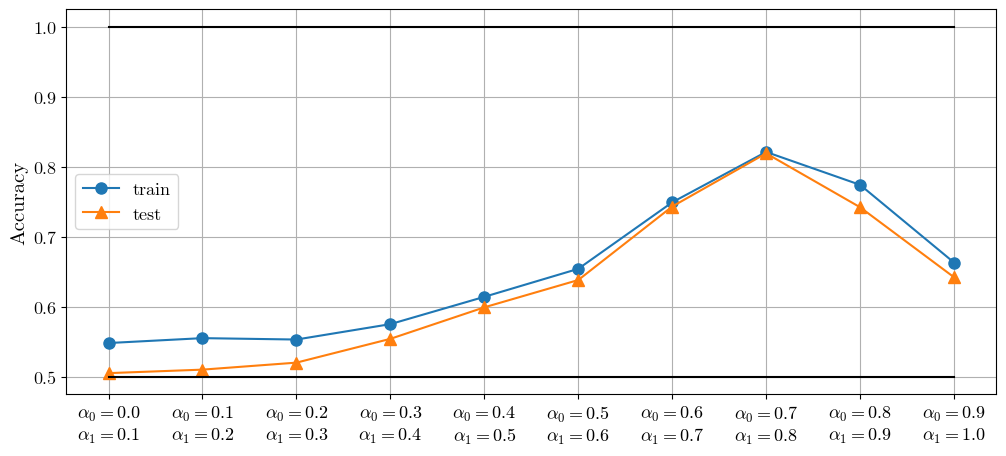

In [21]:
fontsize = 13
x_axis = [i for i in range(len(alphas_sets))]
plt.figure(figsize=(12, 5))
plt.plot(x_axis, accs_train, marker="o", label="train", markersize=8)
plt.plot(x_axis, accs_test, marker="^", label="test", markersize=8)
plt.plot(x_axis, [0.5 for i in range(len(alphas_sets))], color="black")
plt.plot(x_axis, [1.0 for i in range(len(alphas_sets))], color="black")
plt.xticks(x_axis, [r"$\alpha_0=" + str(round(alphas_sets[i][0], 2)) + r"$" + "\n" + r"$\alpha_1=" + str(round(alphas_sets[i][1], 2)) + r"$" for i in range(len(alphas_sets))], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize+2)
plt.legend(fontsize=fontsize)
plt.grid()
plt.show()

### Heatmaps

In [39]:
method = 'BFGS'
alphas = [round(0.1*i, 2) for i in range(11)]
channel_func = local_depolarizing_channel #amplitude_damping_channel #

parameters = None
accs_train = 0.5*np.eye(len(alphas))
accs_test = 0.5*np.eye(len(alphas))
for a in range(len(alphas)):    
    for b in range(a):

        x0 = parameters

        alphas_possible = [alphas[a], alphas[b]]
        print(a, b, end="\r")

        dm_train_n = []
        for i in range(n_train):
            alpha = alphas_possible[labels_train[i]] # pick the corresponding alpha
            density_matrix = channel_func(1, dm_train_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
            dm_train_n.append(density_matrix) # store the noised density matrix    

        dm_test_n = []
        for i in range(n_test):
            alpha = alphas_possible[labels_test[i]] # pick the corresponding alpha
            density_matrix = channel_func(1, dm_test_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
            dm_test_n.append(density_matrix) # store the noised density matrix

        f_values, parameters, optimization_result, border = train(dm_train_o, dm_train_n, labels_train, method, x0=x0)

        predictions_train, assignments_train = classify(parameters, dm_train_o, dm_train_n, border) # classify
        predictions_test, assignments_test = classify(parameters, dm_test_o, dm_test_n, border) # classify

        # calculate train accuracy
        n_correct = 0
        for i in range(n_train):
            if labels_train[i] == assignments_train[i]:
                n_correct += 1
        acc_train = n_correct/n_train
        accs_train[a][b] = 1*acc_train
        accs_train[b][a] = 1*acc_train
        # calculate test accuracy
        n_correct = 0
        for i in range(n_test):
            if labels_test[i] == assignments_test[i]:
                n_correct += 1
        acc_test = n_correct/n_test
        accs_test[a][b] = 1*acc_test
        accs_test[b][a] = 1*acc_test

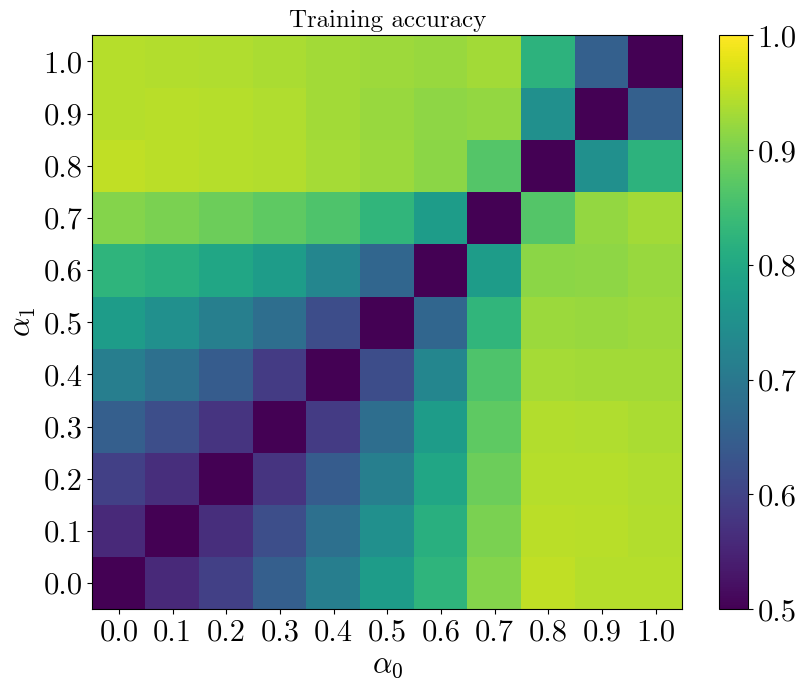

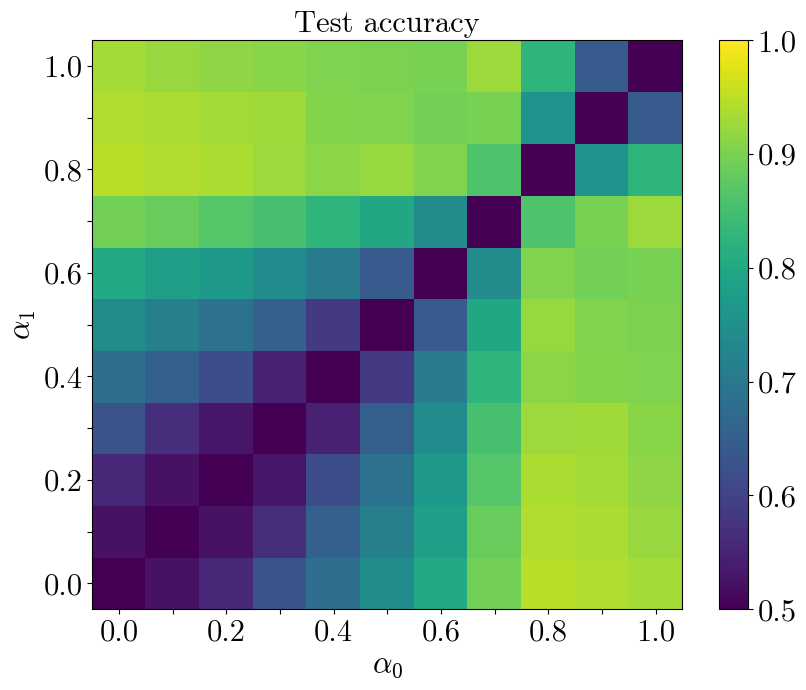

In [40]:
fontsize = 22

Xs, Ys, Zs = alphas, alphas, accs_train
plt.figure(figsize=(8.5, 7))
plt.pcolor(Xs, Ys, Zs, shading='auto', vmin=0.5, vmax=1.0)#)#, interpolation='gaussian', cmap=cmap
plt.xlabel(r'$\alpha_0$', fontsize=fontsize)
plt.ylabel(r'$\alpha_1$', fontsize=fontsize)
plt.title(r'Training accuracy', fontsize=18)
plt.xticks(alphas, alphas, fontsize=fontsize)
plt.yticks(alphas, alphas, fontsize=fontsize)
plt.colorbar().ax.tick_params(labelsize=fontsize)
plt.tight_layout()
# plt.savefig('Atrain-original+noised-rxrz-D.pdf', bbox_inches='tight')
plt.show()

Xs, Ys, Zs = alphas, alphas, accs_test
plt.figure(figsize=(8.5, 7))
plt.pcolor(Xs, Ys, Zs, shading='auto', snap=False, vmin=0.5, vmax=1.0)#)#, interpolation='gaussian', cmap=cmap
plt.xlabel(r'$\alpha_0$', fontsize=fontsize)
plt.ylabel(r'$\alpha_1$', fontsize=fontsize)
plt.title(r'Test accuracy', fontsize=fontsize)
plt.xticks(alphas, [alphas[i] if i%2==0 else None for i in range(len(alphas))], fontsize=fontsize)
plt.yticks(alphas, [alphas[i] if i%2==0 else None for i in range(len(alphas))], fontsize=fontsize)
plt.colorbar().ax.tick_params(labelsize=fontsize)
plt.tight_layout()
# plt.savefig('Atest-original+noised-D-hea-2q-1l.pdf', bbox_inches='tight')
plt.show()

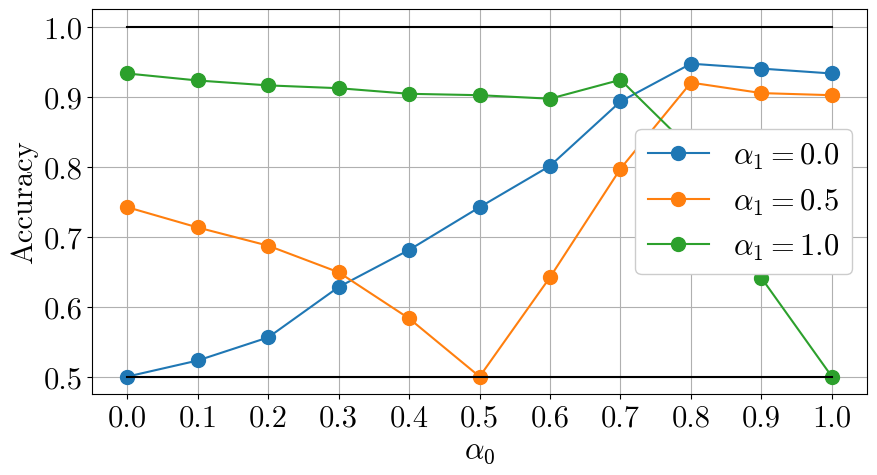

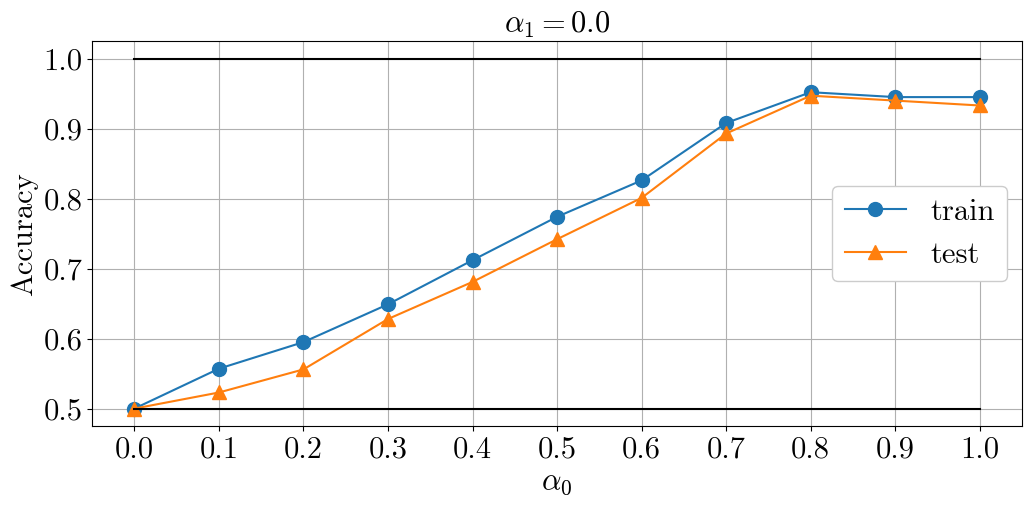

In [67]:
index = 7
fontsize = 22
markersize = 10

indices = [0, 5, 10]
plt.figure(figsize=(10, 5))
for index in indices:
    plt.plot(alphas, accs_test[index], label=r"$\alpha_1=" + str(alphas[index]) + "$", marker="o", markersize=markersize)
plt.plot(alphas, [0.5 for i in range(len(alphas))], color="black")
plt.plot(alphas, [1.0 for i in range(len(alphas))], color="black")
plt.xticks(alphas, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"$\alpha_0$", fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.legend(framealpha=1, fontsize=fontsize)
plt.grid()
plt.show()

index = 0
plt.figure(figsize=(12, 5))
plt.plot(alphas, accs_train[index], marker="o", label="train", markersize=markersize)
plt.plot(alphas, accs_test[index], marker="^", label="test", markersize=markersize)
plt.plot(alphas, [0.5 for i in range(len(alphas))], color="black")
plt.plot(alphas, [1.0 for i in range(len(alphas))], color="black")
plt.xticks(alphas, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"$\alpha_0$", fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.title(r"$\alpha_1=" + str(alphas[index]) + "$", fontsize=fontsize)
plt.legend(framealpha=1, fontsize=fontsize)
plt.grid()
plt.show()

# Noised only

### Trainer, classifier

In [15]:
def train(dms_n, labels, method, x0=None):
    
    f_values = [] # loss function values container
    n_train = len(labels) # training set size 

    obs = Z
    
    # trace function labeler
    def fun(x):
        
        unitary = xz_rot(x) # construct the ansatz
        
        predictions = [] # predictions container
        for i in range(n_train):
            
            density_matrix = dms_n[i] # construct the density matrix
            density_matrix = unitary.dot(density_matrix).dot(unitary.conj().T) # act with the ansatz
            
            # prediction = trace(dot(density_matrix, obs)).real # calculate the prediction (trace)
            prediction = (1 + trace(dot(density_matrix, obs)).real)/2 # calculate the prediction (trace)
            predictions.append(prediction) # store the prediction
        
        f = loglike_cost(labels, predictions) # feed predictions and labels into the least squares function
        f_values.append(f) # store the value of the cost
    
        return f
    
    n_pars = 2 # number of parameters in our ansatz
    bounds = None#[(-4*pi, 4*pi) for i in range(n_pars)] 
    if x0 is None:
        x0 = [random.uniform(-4*pi, 4*pi) for i in range(n_pars)] # initial parameters of the ansatz
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method) # optimization routine
    
    parameters = optimization_result.x # extract optimal ansatz parameters
    
    ### OPTIMAL BORDER###
    #get the predictions using the optimal parameters
    # unitary = su2(2, parameters) # construct the ansatz
    unitary = xz_rot(parameters)
    predictions = [] # predictions container
    for i in range(n_train):

        density_matrix = dms_n[i] # construct the density matrix
        density_matrix = unitary.dot(density_matrix).dot(unitary.conj().T) # act with the ansatz
        
        # prediction = trace(dot(density_matrix, obs)).real # calculate the prediction (trace)
        prediction = (1 + trace(dot(density_matrix, obs)).real)/2 # calculate the prediction (trace)
        predictions.append(prediction) # store the prediction
        
    #sort predictions in increasing order
    data = pd.DataFrame({'preds':predictions, 'labels':labels})
    data = data.sort_values(by = 'preds')
    predictions = data['preds'].values
    labels = data['labels'].values
    
    #train_accuracy for finding optimal border
    best_accuracy = 0
    for i in range(1, n_train):
        labels_pred = [0]*i + [1]*(n_train-i)
        accuracy = accuracy_score(labels, labels_pred)
        if accuracy>best_accuracy:
            best_accuracy = accuracy
            border = predictions[i]
    
    return f_values, parameters, optimization_result, border

In [16]:
def classify(parameters, dms_n, border):
    
    assignments = [] # classification assignments container  
    predictions = [] # predictions container
    n_test = len(dms_n) # validation set size 
    
    obs = Z
    
    unitary = xz_rot(parameters) # construct the ansatz with optimal parameters
    
    for i in range(n_test):

        density_matrix = dms_n[i] # construct the density matrix
        density_matrix = unitary.dot(density_matrix).dot(unitary.conj().T) # act with the ansatz
        
        # prediction = trace(dot(density_matrix, obs)).real # calculate the prediction (trace)
        prediction = (1 + trace(dot(density_matrix, obs)).real)/2 # calculate the prediction (trace)
        predictions.append(prediction) # store the prediction
        
        # classify (assign a label)
        # the optimal value of 'border' you need to find
        if prediction < border: 
            assignment = 0
        elif prediction >= border:
            assignment = 1
        assignments.append(assignment) # store the label
        
    return predictions, assignments

### Training

In [23]:
alphas_possible = [0.0, 0.75] # alphas to classify between
channel_func = local_depolarizing_channel #

In [24]:
dm_train_n = []
for i in range(n_train):
    alpha = alphas_possible[labels_train[i]] # pick the corresponding alpha
    density_matrix = channel_func(1, dm_train_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
    dm_train_n.append(density_matrix) # store the noised density matrix    
    
dm_test_n = []
for i in range(n_test):
    alpha = alphas_possible[labels_test[i]] # pick the corresponding alpha
    density_matrix = channel_func(1, dm_test_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
    dm_test_n.append(density_matrix) # store the noised density matrix

Completed in 0.655099630355835
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


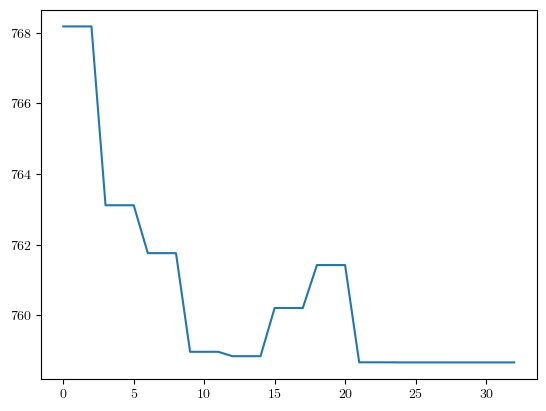

In [25]:
method = 'L-BFGS-B'

start_time = time.time()
f_values, parameters, optimization_result, border = train(dm_train_n, labels_train, method, x0=None)
print('Completed in', time.time() - start_time)
print(optimization_result.message)

x_axis = np.arange(len(f_values))
plt.plot(x_axis, f_values)
plt.show()

In [26]:
predictions_train, assignments_train = classify(parameters, dm_train_n, border) # classify
predictions_test, assignments_test = classify(parameters, dm_test_n, border) # classify

# calculate the accuracy
n_correct = 0
for i in range(n_train):
    if labels_train[i] == assignments_train[i]:
        n_correct += 1
acc_train = n_correct/n_train

# calculate the accuracy
n_correct = 0
for i in range(n_test):
    if labels_test[i] == assignments_test[i]:
        n_correct += 1
acc_test = n_correct/n_test

print("Accuracy:")
print("\t train:  ", acc_train)
print("\t test:   ", acc_test)

Accuracy:
	 train:   0.749
	 test:    0.761


#### Plots

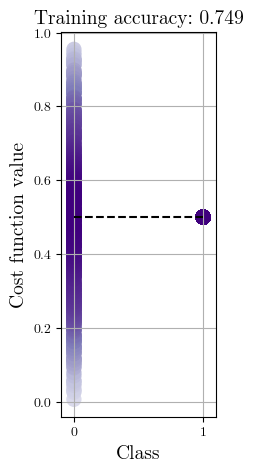

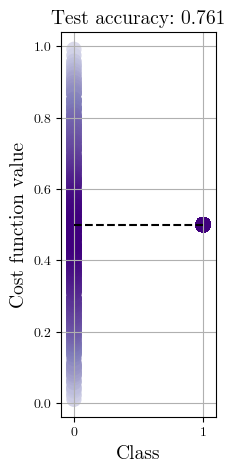

In [27]:
class_labels = [0, 1]
n_classes = len(class_labels)

predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_train):
    for j in range(n_classes):
        if labels_train[i] == class_labels[j]:
            predictions_plot[j].append(predictions_train[i])
cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0.25, 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('Purples', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=border, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Training accuracy: ' + str(acc_train), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
# plt.ylim(-0.3, 0.3)
plt.grid()
plt.show()

# plot all the stuff
predictions_plot = [[] for i in range(n_classes)] 
for i in range(n_test):
    for j in range(n_classes):
        if labels_test[i] == class_labels[j]:
            predictions_plot[j].append(predictions_test[i])
cmap = plt.get_cmap('Purples')
colors = cmap(np.linspace(0.25, 1, cmap.N))
cmap = LinearSegmentedColormap.from_list('Purples', colors)
plt.figure(figsize=(n_classes, 5))
for i in range(n_classes):
    x = np.array([class_labels[i]]*len(predictions_plot[i]))
    y = np.array(predictions_plot[i])
    c = gaussian_kde(predictions_plot[i])(predictions_plot[i])
    idx = c.argsort()
    x, y, c = x[idx], y[idx], c[idx]
    plt.scatter(x, y, c=c, cmap=cmap, s=100)
for i in range(n_classes - 1):
    plt.hlines(y=border, xmin=class_labels[0], xmax=class_labels[-1], color='black', linestyle='dashed')
plt.xlabel('Class', fontsize=14)
plt.ylabel('Cost function value', fontsize=14)
plt.xticks(class_labels, [str(c) for c in class_labels])
plt.title('Test accuracy: ' + str(acc_test), fontsize=14)
plt.xlim(xmin=class_labels[0]-0.1, xmax=class_labels[-1]+0.1)
# plt.ylim(-0.3, 0.3)
plt.grid()
plt.show()

### Acc vs Alphas

### 2D

In [26]:
method = 'L-BFGS-B'
alphas_sets = [(0.1*i, 0.1*i+0.1) for i in range(10)] #+ [(0.0, 1.0)]
channel_func = local_depolarizing_channel #amplitude_damping_channel #

In [27]:
accs_train = []
accs_test = []
for a in range(len(alphas_sets)):
    
    if a == 0:
        x0 = None
    else:
        x0 = parameters
    
    alphas_possible = alphas_sets[a]
    # print("alphas:", np.round(alphas_possible, 2), end="\r")
    
    dm_train_n = []
    for i in range(n_train):
        alpha = alphas_possible[labels_train[i]] # pick the corresponding alpha
        density_matrix = channel_func(1, dm_train_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
        dm_train_n.append(density_matrix) # store the noised density matrix    

    dm_test_n = []
    for i in range(n_test):
        alpha = alphas_possible[labels_test[i]] # pick the corresponding alpha
        density_matrix = channel_func(1, dm_test_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
        dm_test_n.append(density_matrix) # store the noised density matrix

    f_values, parameters, optimization_result, border = train(dm_train_o, dm_train_n, labels_train, method, x0=x0)

    predictions_train, assignments_train = classify(parameters, dm_train_o, dm_train_n, border) # classify
    predictions_test, assignments_test = classify(parameters, dm_test_o, dm_test_n, border) # classify

    # calculate the accuracy
    n_correct = 0
    for i in range(n_train):
        if labels_train[i] == assignments_train[i]:
            n_correct += 1
    acc_train = n_correct/n_train

    # calculate the accuracy
    n_correct = 0
    for i in range(n_test):
        if labels_test[i] == assignments_test[i]:
            n_correct += 1
    acc_test = n_correct/n_test
    
    accs_train.append(acc_train)
    accs_test.append(acc_test)

    
    # print("\t train:", acc_train)
    # print("\t test: ", acc_test)

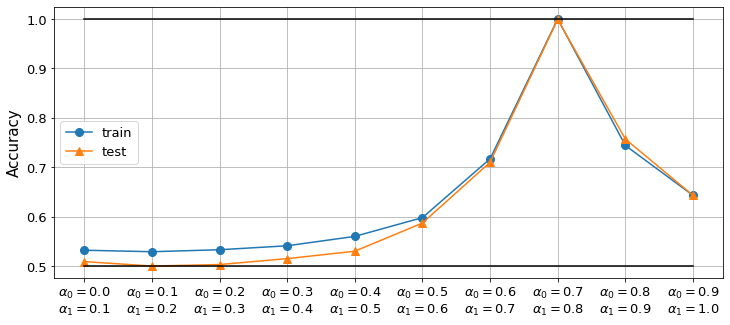

In [28]:
fontsize = 13
x_axis = [i for i in range(len(alphas_sets))]
plt.figure(figsize=(12, 5))
plt.plot(x_axis, accs_train, marker="o", label="train", markersize=8)
plt.plot(x_axis, accs_test, marker="^", label="test", markersize=8)
plt.plot(x_axis, [0.5 for i in range(len(alphas_sets))], color="black")
plt.plot(x_axis, [1.0 for i in range(len(alphas_sets))], color="black")
plt.xticks(x_axis, [r"$\alpha_0=" + str(round(alphas_sets[i][0], 2)) + r"$" + "\n" + r"$\alpha_1=" + str(round(alphas_sets[i][1], 2)) + r"$" for i in range(len(alphas_sets))], fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize+2)
plt.legend(fontsize=fontsize)
plt.grid()
plt.show()

### Heatmaps

In [36]:
method = 'BFGS'
alphas = linspace(0, 1, 101)
channel_func = local_depolarizing_channel #amplitude_damping_channel #

parameters = None
accs_train = 0.5*np.eye(len(alphas))
accs_test = 0.5*np.eye(len(alphas))
for a in range(len(alphas)):    
    for b in range(a):

        x0 = None

        alphas_possible = [alphas[a], alphas[b]]
        print(a, b, end="\r")

        dm_train_n = []
        for i in range(n_train):
            alpha = alphas_possible[labels_train[i]] # pick the corresponding alpha
            density_matrix = channel_func(1, dm_train_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
            dm_train_n.append(density_matrix) # store the noised density matrix    

        dm_test_n = []
        for i in range(n_test):
            alpha = alphas_possible[labels_test[i]] # pick the corresponding alpha
            density_matrix = channel_func(1, dm_test_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
            dm_test_n.append(density_matrix) # store the noised density matrix

        f_values, parameters, optimization_result, border = train(dm_train_n, labels_train, method, x0=x0)

        predictions_train, assignments_train = classify(parameters, dm_train_n, border) # classify
        predictions_test, assignments_test = classify(parameters, dm_test_n, border) # classify

        # calculate the accuracy
        n_correct = 0
        for i in range(n_train):
            if labels_train[i] == assignments_train[i]:
                n_correct += 1
        acc_train = n_correct/n_train

        # calculate the accuracy
        n_correct = 0
        for i in range(n_test):
            if labels_test[i] == assignments_test[i]:
                n_correct += 1
        acc_test = n_correct/n_test

        accs_train[a][b] = 1*acc_train
        accs_test[a][b] = 1*acc_test

        accs_train[b][a] = 1*acc_train
        accs_test[b][a] = 1*acc_test

/home/kardashin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: shading value 'none' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  """


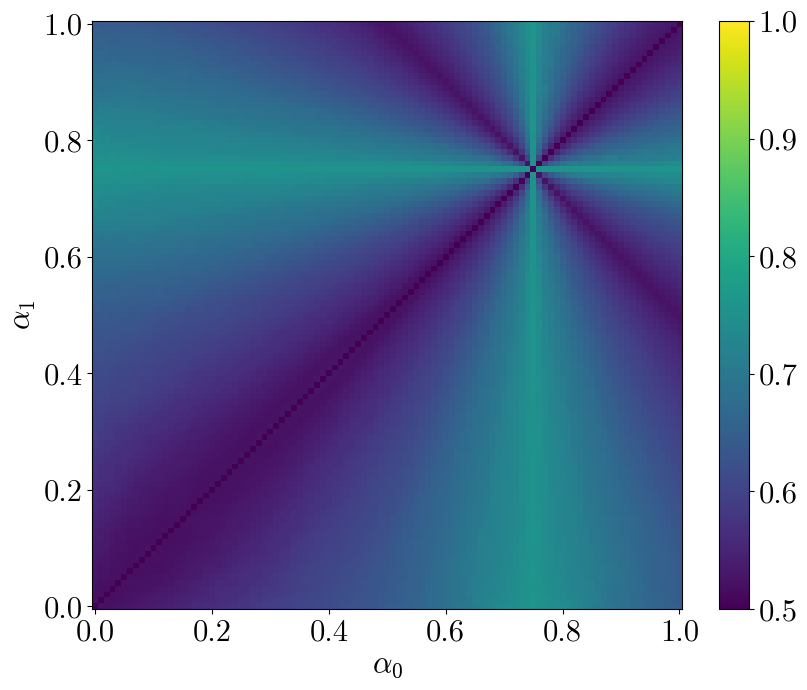

/home/kardashin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: shading value 'none' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.


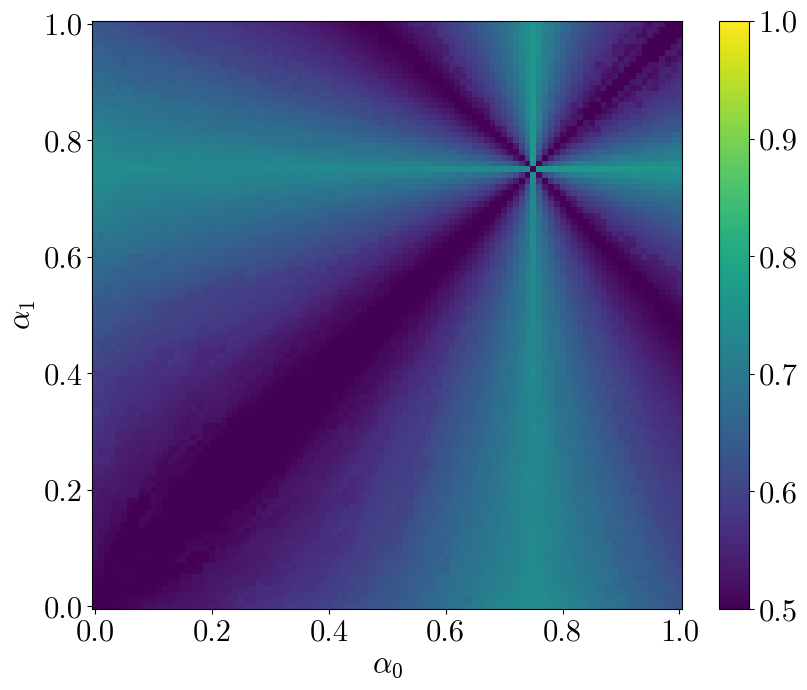

In [46]:
fontsize = 22

Xs, Ys, Zs = alphas, alphas, accs_train
plt.figure(figsize=(8.5, 7))
plt.pcolormesh(Xs, Ys, Zs, shading='none', vmin=0.5, vmax=1.0)#)#, cmap=cmap
plt.xlabel(r'$\alpha_0$', fontsize=fontsize)
plt.ylabel(r'$\alpha_1$', fontsize=fontsize)
# plt.title(r'Training accuracy', fontsize=18)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.colorbar().ax.tick_params(labelsize=fontsize)
plt.tight_layout()
plt.savefig('Atrain-noised-rxrz.pdf', bbox_inches='tight', transparent=True)
plt.show()

Xs, Ys, Zs = alphas, alphas, accs_test
plt.figure(figsize=(8.5, 7))
plt.pcolormesh(Xs, Ys, Zs, shading='none', vmin=0.5, vmax=1.0)#)#, interpolation='gaussian', cmap=cmap
plt.xlabel(r'$\alpha_0$', fontsize=fontsize)
plt.ylabel(r'$\alpha_1$', fontsize=fontsize)
# plt.title(r'Test accuracy', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.colorbar().ax.tick_params(labelsize=fontsize)
plt.tight_layout()
plt.savefig('Atest-noised-rxrz.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [17]:
method = 'BFGS'
index = 0
n_runs = 30
n_train = 1000 # train set size
n_test = 1000 # test set size
    
alphas = np.round(linspace(0, 1, 21), 2)
channel_func = local_depolarizing_channel #amplitude_damping_channel 

accs_train = []
accs_test = []
for r in range(n_runs):

    dm_train_o = [] # container for original density matrices
    labels_train = [] # container for correct labels
    dm_test_o = [] # container for original density matrices
    for i in range(n_train):
        labels_train.append(random.randint(0, 1)) # store the class label
        # state_vector = np.array(qp.rand_ket(2)) # generate a random state
        # density_matrix = outer(state_vector, state_vector.conj().T) # consturct the corresponding density matrix
        density_matrix = np.array(qp.rand_dm_hs(2))
        dm_train_o.append(density_matrix) # store the original density matrix

    dm_test_o = [] # container for original density matrices
    labels_test = [] # container for correct labels
    dm_test_o = [] # container for original density matrices
    for i in range(n_test):
        labels_test.append(random.randint(0, 1)) # store the class label
        # state_vector = np.array(qp.rand_ket(2)) # generate a random state
        # density_matrix = outer(state_vector, state_vector.conj().T) # consturct the corresponding density matrix
        density_matrix = np.array(qp.rand_dm_hs(2))
        dm_test_o.append(density_matrix) # store the original density matrix

    parameters = None
    accs_train_loc = []
    accs_test_loc = []
    for a in range(len(alphas)):    

            # x0 = parameters
            x0 = None

            alphas_possible = [alphas[a], alphas[index]]
            print(r, a, end="\r")

            dm_train_n = []
            for i in range(n_train):
                alpha = alphas_possible[labels_train[i]] # pick the corresponding alpha
                density_matrix = channel_func(1, dm_train_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
                dm_train_n.append(density_matrix) # store the noised density matrix    

            dm_test_n = []
            for i in range(n_test):
                alpha = alphas_possible[labels_test[i]] # pick the corresponding alpha
                density_matrix = channel_func(1, dm_test_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
                dm_test_n.append(density_matrix) # store the noised density matrix

            f_values, parameters, optimization_result, border = train(dm_train_n, labels_train, method, x0=x0)

            predictions_train, assignments_train = classify(parameters, dm_train_n, border) # classify
            predictions_test, assignments_test = classify(parameters, dm_test_n, border) # classify

            # calculate the accuracy
            n_correct = 0
            for i in range(n_train):
                if labels_train[i] == assignments_train[i]:
                    n_correct += 1
            acc_train = n_correct/n_train
            accs_train_loc.append(acc_train)
            # calculate the accuracy
            n_correct = 0
            for i in range(n_test):
                if labels_test[i] == assignments_test[i]:
                    n_correct += 1
            acc_test = n_correct/n_test
            accs_test_loc.append(acc_test)
    accs_train.append(accs_train_loc)
    accs_test.append(accs_test_loc)

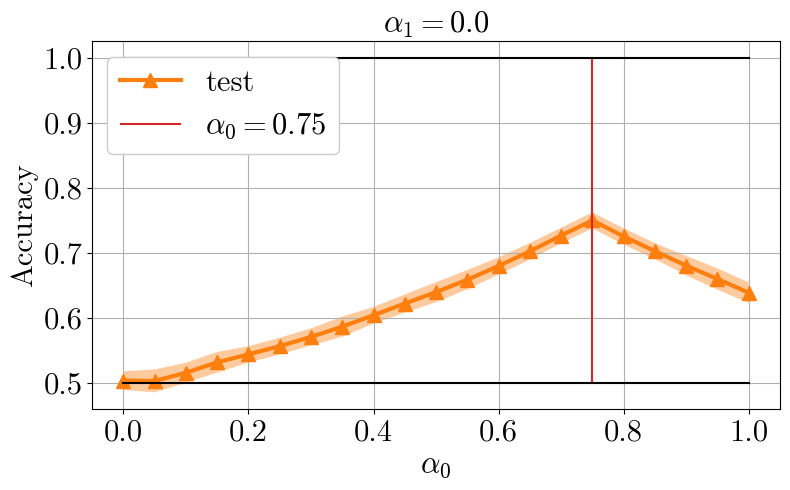

In [18]:
fontsize = 22
markersize = 10
markevery = 1
linewidth = 3
plt.figure(figsize=(8, 5))
# plt.fill_between(alphas, mean(accs_train, axis=0) - np.std(accs_train, axis=0), mean(accs_train, axis=0) + np.std(accs_train, axis=0), alpha=0.4, color="C0", edgecolor="none")
plt.fill_between(alphas, np.mean(accs_test, axis=0) - np.std(accs_test, axis=0), np.mean(accs_test, axis=0) + np.std(accs_test, axis=0), alpha=0.4, color="C1", edgecolor="none")
# plt.plot(alphas, mean(accs_train, axis=0), marker="o", label="train", color="C0", linewidth=linewidth, markersize=markersize, markevery=markevery)
plt.plot(alphas, np.mean(accs_test, axis=0), marker="^", label="test", color="C1", linewidth=linewidth, markersize=markersize, markevery=markevery)
plt.vlines(x=0.75, ymin=0.5, ymax=1, color="tab:red", label=r"$\alpha_0 = 0.75$")
plt.plot(alphas, [0.5 for i in range(len(alphas))], color="black")
plt.plot(alphas, [1.0 for i in range(len(alphas))], color="black")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"$\alpha_0$", fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.title(r"$\alpha_1=" + str(alphas[index]) + "$", fontsize=fontsize)
plt.legend(framealpha=1, fontsize=fontsize, loc=2)
plt.grid()
plt.tight_layout()
# plt.savefig("accuracy-noised+original-depolarizing-xz-alpha1=" + str(alphas[index]) + ".pdf", bbox_inches='tight', transparent=True)
plt.show()

In [19]:
# accs_test_n = array(accs_test)

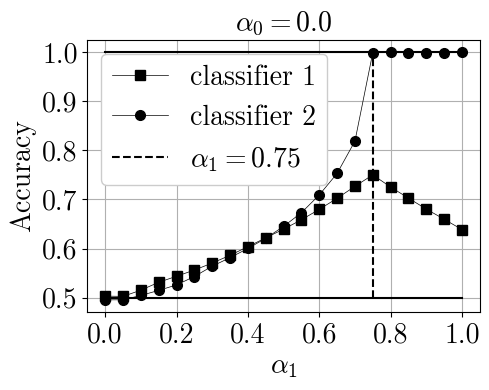

In [26]:
fontsize = 20
markersize = 7
markevery = 1
linewidth = 0.5
capsize = 5
plt.figure(figsize=(5, 4))
# plt.errorbar(alphas, np.mean(accs_test_n, axis=0), yerr=np.std(accs_test, axis=0), capsize=capsize, linestyle="-", markersize=markersize, marker="s", label="classifier 1", linewidth=linewidth, color="black")
# plt.errorbar(alphas, np.mean(accs_test_no, axis=0), yerr=np.std(accs_test, axis=0), capsize=capsize, linestyle="-", markersize=markersize, marker="o", label="classifier 2", linewidth=linewidth, color="black")
plt.plot(alphas, np.mean(accs_test_n, axis=0), linestyle="-", markersize=markersize, marker="s", label="classifier 1", linewidth=linewidth, color="black")
plt.plot(alphas, np.mean(accs_test_no, axis=0), linestyle="-", markersize=markersize, marker="o", label="classifier 2", linewidth=linewidth, color="black")
plt.vlines(x=0.75, ymin=0.5, ymax=1, label=r"$\alpha_1 = 0.75$", linestyle="--", color="black")
plt.plot(alphas, [0.5 for i in range(len(alphas))], color="black")
plt.plot(alphas, [1.0 for i in range(len(alphas))], color="black")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"$\alpha_1$", fontsize=fontsize)
plt.ylabel("Accuracy", fontsize=fontsize)
plt.title(r"$\alpha_0=" + str(alphas[index]) + "$", fontsize=fontsize)
plt.legend(framealpha=1, fontsize=fontsize, loc=2)
plt.grid()
plt.tight_layout()
plt.savefig("KardashinAS_fig1.pdf", bbox_inches='tight', transparent=True)
plt.show()

### Sample size

In [190]:
n_runs = 100

n_train = 1000 # train set size
n_test = 1000 # test set size
chunk_size = 10
chunks = arange(chunk_size, n_train+chunk_size, chunk_size)
# chunks = np.concatenate( (arange(2, chunk_size, 1), arange(chunk_size, n_train+chunk_size, chunk_size)) )

# n_train = 1024 # train set size
# n_test = 1024 # test set size
# chunks = [2**i for i in range(2, 11)]


alphas_possible = [0.0, 1.0] # alphas to classify between
method = 'BFGS'
channel_func = local_depolarizing_channel

In [191]:
accs_train = []
accs_test = []

for r in range(n_runs):

    print("r:", r)
    
    dm_train_o = [] # container for original density matrices
    labels_train = [] # container for correct labels
    dm_test_o = [] # container for original density matrices
    for i in range(n_train):
        labels_train.append(random.randint(0, 1)) # store the class label
        density_matrix = np.array(qp.rand_dm_hs(2))
        dm_train_o.append(density_matrix) # store the original density matrix

    dm_test_o = [] # container for original density matrices
    labels_test = [] # container for correct labels
    dm_test_o = [] # container for original density matrices
    for i in range(n_test):
        labels_test.append(random.randint(0, 1)) # store the class label
        density_matrix = np.array(qp.rand_dm_hs(2))
        dm_test_o.append(density_matrix) # store the original density matrix

    dm_train_n = []
    for i in range(n_train):
        alpha = alphas_possible[labels_train[i]] # pick the corresponding alpha
        density_matrix = channel_func(1, dm_train_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
        dm_train_n.append(density_matrix) # store the noised density matrix    

    dm_test_n = []
    for i in range(n_test):
        alpha = alphas_possible[labels_test[i]] # pick the corresponding alpha
        density_matrix = channel_func(1, dm_test_o[i], alpha, 0) # act with the local_depolarizing_channel amplitude_damping_channel
        dm_test_n.append(density_matrix) # store the noised density matrix
        
        
    x0 = [random.uniform(-2*pi, 2*pi) for i in range(2)]
    
    accs_train_run = []
    accs_test_run = []
    for chunk in chunks:
        
        print("\tchunk:", chunk, end="\r")
        
        f_values, parameters, optimization_result, border = train(dm_train_n[:chunk], labels_train[:chunk], method, x0=x0)

        predictions_train, assignments_train = classify(parameters, dm_train_n[:chunk], border) # classify
        predictions_test, assignments_test = classify(parameters, dm_test_n, border) # classify
        
        # calculate the accuracy
        n_correct = 0
        for i in range(chunk):
            if labels_train[i] == assignments_train[i]:
                n_correct += 1
        acc_train = n_correct/chunk

        # calculate the accuracy
        n_correct = 0
        for i in range(n_test):
            if labels_test[i] == assignments_test[i]:
                n_correct += 1
        acc_test = n_correct/n_test
        
        accs_train_run.append(acc_train)
        accs_test_run.append(acc_test)
    print()
    accs_train.append(accs_train_run)
    accs_test.append(accs_test_run)

r: 0
	chunk: 1000
r: 1
	chunk: 1000
r: 2
	chunk: 1000
r: 3
	chunk: 1000
r: 4
	chunk: 1000
r: 5
	chunk: 1000
r: 6
	chunk: 1000
r: 7
	chunk: 1000
r: 8
	chunk: 1000
r: 9
	chunk: 1000
r: 10
	chunk: 1000
r: 11
	chunk: 1000
r: 12
	chunk: 1000
r: 13
	chunk: 1000
r: 14
	chunk: 1000
r: 15
	chunk: 1000
r: 16
	chunk: 1000
r: 17
	chunk: 1000
r: 18
	chunk: 1000
r: 19
	chunk: 1000
r: 20
	chunk: 1000
r: 21
	chunk: 1000
r: 22
	chunk: 1000
r: 23
	chunk: 1000
r: 24
	chunk: 1000
r: 25
	chunk: 1000
r: 26
	chunk: 1000
r: 27
	chunk: 1000
r: 28
	chunk: 1000
r: 29
	chunk: 1000
r: 30
	chunk: 1000
r: 31
	chunk: 1000
r: 32
	chunk: 1000
r: 33
	chunk: 1000
r: 34
	chunk: 1000
r: 35
	chunk: 1000
r: 36
	chunk: 1000
r: 37
	chunk: 1000
r: 38
	chunk: 1000
r: 39
	chunk: 1000
r: 40
	chunk: 1000
r: 41
	chunk: 1000
r: 42
	chunk: 1000
r: 43
	chunk: 1000
r: 44
	chunk: 1000
r: 45
	chunk: 1000
r: 46
	chunk: 1000
r: 47
	chunk: 1000
r: 48
	chunk: 1000
r: 49
	chunk: 1000
r: 50
	chunk: 1000
r: 51
	chunk: 1000
r: 52
	chunk: 1000
r: 

In [192]:
accs_train_mean = mean(accs_train, axis=0)
accs_test_mean = mean(accs_test, axis=0)

accs_train_std = std(accs_train, axis=0)
accs_test_std = std(accs_test, axis=0)

In [193]:
# accs_train_mean_1 = array(accs_train_mean)
# accs_test_mean_1 = array(accs_test_mean)

# accs_train_std_1 = array(accs_train_std)
# accs_test_std_1 = array(accs_test_std)

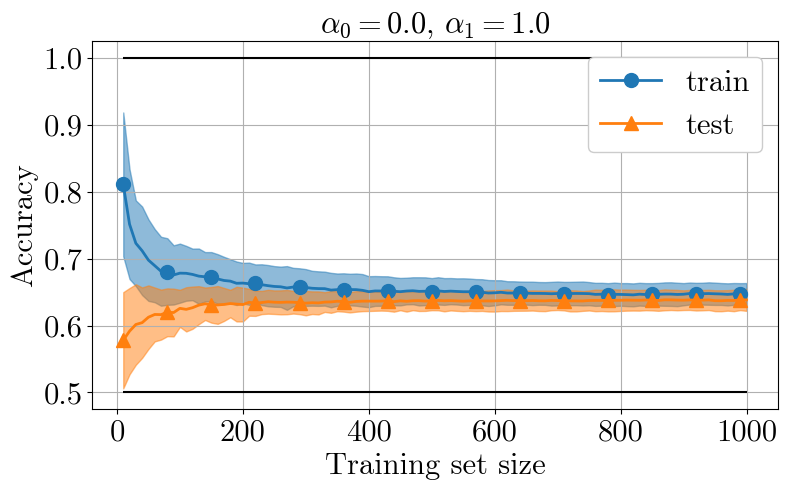

In [194]:
fontsize = 22
markersize = 10
linewidth = 2
markevery = 7

plt.figure(figsize=(8, 5))
x_axis = np.arange(len(alphas)-1)

plt.plot(chunks, accs_train_mean, marker="o", color="C0", markersize=markersize, markevery=markevery, label=r"train", linewidth=linewidth)
plt.plot(chunks, accs_test_mean, marker="^", color="C1", markersize=markersize, markevery=markevery, label=r"test", linewidth=linewidth)

plt.fill_between(chunks, np.max((accs_train_mean-accs_train_std, np.ones(len(chunks))-0.5), axis=0), np.min((accs_train_mean+accs_train_std, np.ones(len(chunks))), axis=0), color="C0", alpha=0.5)
plt.fill_between(chunks, np.max((accs_test_mean-accs_test_std, np.ones(len(chunks))-0.5), axis=0), np.min((accs_test_mean+accs_test_std, np.ones(len(chunks))), axis=0), color="C1", alpha=0.5)

plt.hlines(y=0.5, xmin=chunks[0], xmax=chunks[-1], color="black")
plt.hlines(y=1.0, xmin=chunks[0], xmax=chunks[-1], color="black")

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"Training set size", fontsize=fontsize)
plt.ylabel(r"Accuracy", fontsize=fontsize)
plt.title(r"$\alpha_0=" + str(alphas_possible[0]) + "$, " + r"$\alpha_1=" + str(alphas_possible[1]) + "$", fontsize=fontsize)
plt.legend(fontsize=fontsize, framealpha=1)
plt.grid()
plt.tight_layout()
plt.savefig("accuracy-sample_size-noised_only-a0=" + str(alphas_possible[0]) + "-a1=" + str(alphas_possible[1]) + ".pdf", bbox_inches='tight')
plt.show()

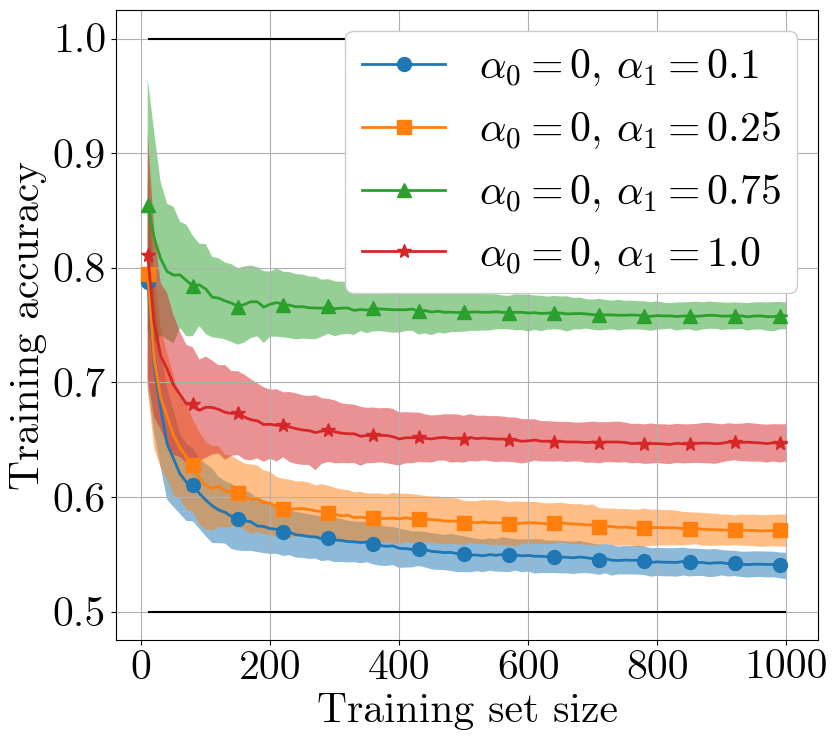

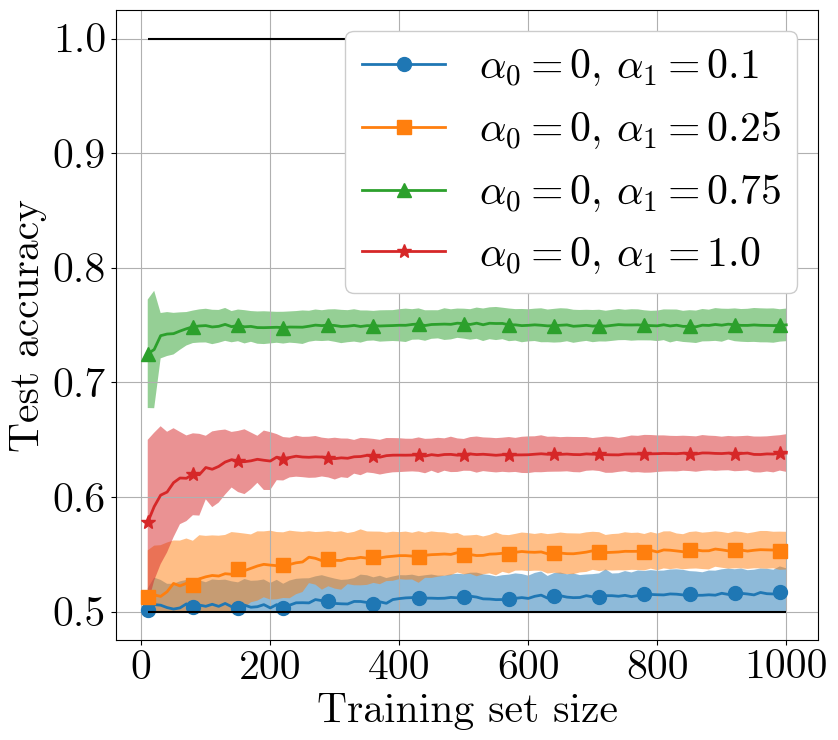

In [221]:
fontsize = 30
markersize = 10
linewidth = 2
markevery = 7

x_axis = np.arange(len(alphas)-1)

plt.figure(figsize=(8.5, 7.5))
plt.plot(chunks, accs_train_mean_01, marker="o", markersize=markersize, markevery=markevery, label=r"$\alpha_0=0$, $\alpha_1=0.1$", linewidth=linewidth)
plt.plot(chunks, accs_train_mean_025, marker="s", markersize=markersize, markevery=markevery, label=r"$\alpha_0=0$, $\alpha_1=0.25$", linewidth=linewidth)
plt.plot(chunks, accs_train_mean_075, marker="^", markersize=markersize, markevery=markevery, label=r"$\alpha_0=0$, $\alpha_1=0.75$", linewidth=linewidth)
plt.plot(chunks, accs_train_mean_1, marker="*", markersize=markersize, markevery=markevery, label=r"$\alpha_0=0$, $\alpha_1=1.0$", linewidth=linewidth)
plt.fill_between(chunks, np.max((accs_train_mean_01-accs_train_std_01, np.ones(len(chunks))-0.5), axis=0), np.min((accs_train_mean_01+accs_train_std_01, np.ones(len(chunks))), axis=0), alpha=0.5)
plt.fill_between(chunks, np.max((accs_train_mean_025-accs_train_std_025, np.ones(len(chunks))-0.5), axis=0), np.min((accs_train_mean_025+accs_train_std_025, np.ones(len(chunks))), axis=0), alpha=0.5)
plt.fill_between(chunks, np.max((accs_train_mean_075-accs_train_std_075, np.ones(len(chunks))-0.5), axis=0), np.min((accs_train_mean_075+accs_train_std_075, np.ones(len(chunks))), axis=0), alpha=0.5)
plt.fill_between(chunks, np.max((accs_train_mean_1-accs_train_std_1, np.ones(len(chunks))-0.5), axis=0), np.min((accs_train_mean_1+accs_train_std_1, np.ones(len(chunks))), axis=0), alpha=0.5)
plt.hlines(y=0.5, xmin=chunks[0], xmax=chunks[-1], color="black")
plt.hlines(y=1.0, xmin=chunks[0], xmax=chunks[-1], color="black")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"Training set size", fontsize=fontsize)
plt.ylabel(r"Training accuracy", fontsize=fontsize)
plt.legend(fontsize=fontsize, framealpha=1, ncol=1)
plt.grid()
plt.tight_layout()
plt.savefig("accuracy-sample_size-noised_only-train.pdf", bbox_inches='tight')
plt.show()

plt.figure(figsize=(8.5, 7.5))
plt.plot(chunks, accs_test_mean_01, marker="o", markersize=markersize, markevery=markevery, label=r"$\alpha_0=0$, $\alpha_1=0.1$", linewidth=linewidth)
plt.plot(chunks, accs_test_mean_025, marker="s", markersize=markersize, markevery=markevery, label=r"$\alpha_0=0$, $\alpha_1=0.25$", linewidth=linewidth)
plt.plot(chunks, accs_test_mean_075, marker="^", markersize=markersize, markevery=markevery, label=r"$\alpha_0=0$, $\alpha_1=0.75$", linewidth=linewidth)
plt.plot(chunks, accs_test_mean_1, marker="*", markersize=markersize, markevery=markevery, label=r"$\alpha_0=0$, $\alpha_1=1.0$", linewidth=linewidth)
plt.fill_between(chunks, np.max((accs_test_mean_01-accs_test_std_01, np.ones(len(chunks))-0.5), axis=0), np.min((accs_test_mean_01+accs_test_std_01, np.ones(len(chunks))), axis=0), alpha=0.5)
plt.fill_between(chunks, np.max((accs_test_mean_025-accs_test_std_025, np.ones(len(chunks))-0.5), axis=0), np.min((accs_test_mean_025+accs_test_std_025, np.ones(len(chunks))), axis=0), alpha=0.5)
plt.fill_between(chunks, np.max((accs_test_mean_075-accs_test_std_075, np.ones(len(chunks))-0.5), axis=0), np.min((accs_test_mean_075+accs_test_std_075, np.ones(len(chunks))), axis=0), alpha=0.5)
plt.fill_between(chunks, np.max((accs_test_mean_1-accs_test_std_1, np.ones(len(chunks))-0.5), axis=0), np.min((accs_test_mean_1+accs_test_std_1, np.ones(len(chunks))), axis=0), alpha=0.5)
plt.hlines(y=0.5, xmin=chunks[0], xmax=chunks[-1], color="black")
plt.hlines(y=1.0, xmin=chunks[0], xmax=chunks[-1], color="black")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel(r"Training set size", fontsize=fontsize)
plt.ylabel(r"Test accuracy", fontsize=fontsize)
plt.legend(fontsize=fontsize, framealpha=1, ncol=1)
plt.grid()
plt.tight_layout()
plt.savefig("accuracy-sample_size-noised_only-test.pdf", bbox_inches='tight')
plt.show()